In [1]:
import numpy as np
import pandas as pd
import h5py
import torch

from CommonFun import model_eva
# mymodel
from config import config as cfg
from layers.mergeBlock import mergeBlock1 as mergeBlock
from AEGAN import AE

# pysteps
from pysteps import nowcasts
from pysteps.motion.lucaskanade import dense_lucaskanade
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib import font_manager
from matplotlib import rcParams

plt.rcParams['font.sans-serif'] = ['SimHei']  ###防止无法显示中文并设置黑体
plt.rcParams['axes.unicode_minus'] = False  ###用来正常显示负号

TimesSong = FontProperties(fname="C:\\Users\\林子扬\\Desktop\\TimesSong.ttf")
font_manager.fontManager.addfont("C:\\Users\\林子扬\Desktop\\TimesSong.ttf")

# 全局设置字体及大小，设置公式字体即可
config = {
    "mathtext.fontset":'stix',
    "font.family":'serif',
    "font.serif": ['TimesSong'],
    'axes.unicode_minus': False, # 处理负号，即-号
    "font.size": 12
}

rcParams.update(config)

Pysteps configuration file found at: C:\Users\林子扬\pysteps\pystepsrc



In [2]:
bilv = [0.1, 0.3, 0.3, 0.3]
# 模型参数
input_channels = 1
output_channels = 1
time_steps = 5
forecast_steps = 10
batch_size = 10
output_shape = 128

model = AE(input_channels, output_channels, output_shape, batch_size,time_steps, forecast_steps)
# 加载预训练好的 encoder 模型
# PATH='./en.pth'
PATH = 'D:\\Project\\DL_leida_rain\\pth\\313\\en.pth'
model.encoder.load_state_dict(torch.load(PATH, map_location='cpu'))
model.to(cfg().device)

# 融合模块 (mergeBlock)
mBen = mergeBlock(time_steps, 16)
# PATH = './mBen.pth'
PATH = 'D:\\Project\\DL_leida_rain\\pth\\313\\mBen.pth'
mBen.load_state_dict(torch.load(PATH, map_location='cpu'))
mBen.to(cfg().device)

d:\anaconda\envs\pyepch\lib\site-packages\torch\nn\init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


mergeBlock1(
  (avg_pool): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=5, out_features=0, bias=True)
  (fc2): Linear(in_features=0, out_features=5, bias=True)
  (convout): Conv3d(5, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [3]:
dataset = h5py.File(cfg().datatest, 'r')
dataset = dataset['train']

# 数据读取和预处理
def datapre(st, ed, dataset=dataset):
    train_data = torch.zeros(batch_size, 15, 4, 128, 128)
    train_data[:, :, :, 13:114, 13:114] = torch.Tensor(dataset[st:ed, :, :, :, :])
    # train_data[:, :, :, 13:114,13:114] = torch.Tensor(dataset[10:batch_size+10, :, :, :, :])
    train_data = train_data * 95 / 255 - 10
    train_data = torch.swapaxes(train_data, 0, 1)
    train_data = (train_data[:, :, 0, :, :] * bilv[0] +
                  train_data[:, :, 1, :, :] * bilv[1] +
                  train_data[:, :, 2, :, :] * bilv[2] +
                  train_data[:, :, 3, :, :] * bilv[3]).reshape(
        15, batch_size, 1, output_shape, output_shape)

    inputx = train_data[:5, :, :, :, :].to(cfg().device)
    y = train_data[5:, :, :, :, :].to(cfg().device)
    return inputx, y  # T | B | C | H | W

In [4]:
nowcast_method = nowcasts.get_method("steps")


def steppre(inputx):
    """
    inputx: T | B | C | H | W 
    """
    _, B, C, _, _ = inputx.size()
    # set nowcast parameters
    n_leadtimes = 10
    seed = 10
    R_fout = np.zeros((n_leadtimes, B, C, 101, 101))
    for i in range(B):
        V = dense_lucaskanade(inputx[:, i, 0, 13:114, 13:114].numpy())  # T | H | W
        R_f = nowcast_method(
            inputx[:, i, 0, 13:114, 13:114].numpy(),  # T | H | W 
            V,
            timesteps=n_leadtimes,
            n_ens_members=1,
            # n_cascade_levels=4,
            precip_thr=-10.0,
            kmperpixel=1.0,
            timestep=6,
            # decomp_method="fft",
            # bandpass_filter_method="gaussian",
            # noise_method="nonparametric",
            # vel_pert_method="bps",
            mask_method="incremental",
            seed=seed,
        )  # 1 | forecast_step | H | W
        R_fout[:, i, 0, :, :] = R_f[0, :, :, :]
    return R_fout  # forecast_step | B | C | H | W

In [5]:
# st=500
st=1124
inputx, y = datapre(st, st + 10)
inputxstep = torch.where(inputx == -10, 0, inputx)

In [6]:
# model
with torch.no_grad():
    out= model.encoder(inputx, model.hid1, model.hid2, model.hid3, model.hid4, mBen, model.time_steps,
                            model.forecast_steps)  # forecast_step | B | C | H | W
    # out,te1,te2,te3,te4 = model.encoder(inputx, model.hid1, model.hid2, model.hid3, model.hid4, mBen, model.time_steps,
    #                         model.forecast_steps)  # forecast_step | B | C | H | W

In [7]:
realx=np.zeros((15,10,1,128,128))
realx[:5,:,:,:,:]=inputx
realx[5:,:,:,:,:]=y 

In [8]:
levels=[-100,5,10,15,20,25,30,35,40,45,50,55,60,65,70,100] #14
colors=['#ffffff','#01a0f6','#00ecec','#6dfa3d','#00d800','#019000','#ffff00','#e7c000','#ff9000','#ff0000','#d60000','#c00000','#ff00f0','#9600b4','#ad90f0']
def delxysticks(ax):
    ax.set_xticks([])
    ax.set_yticks([])

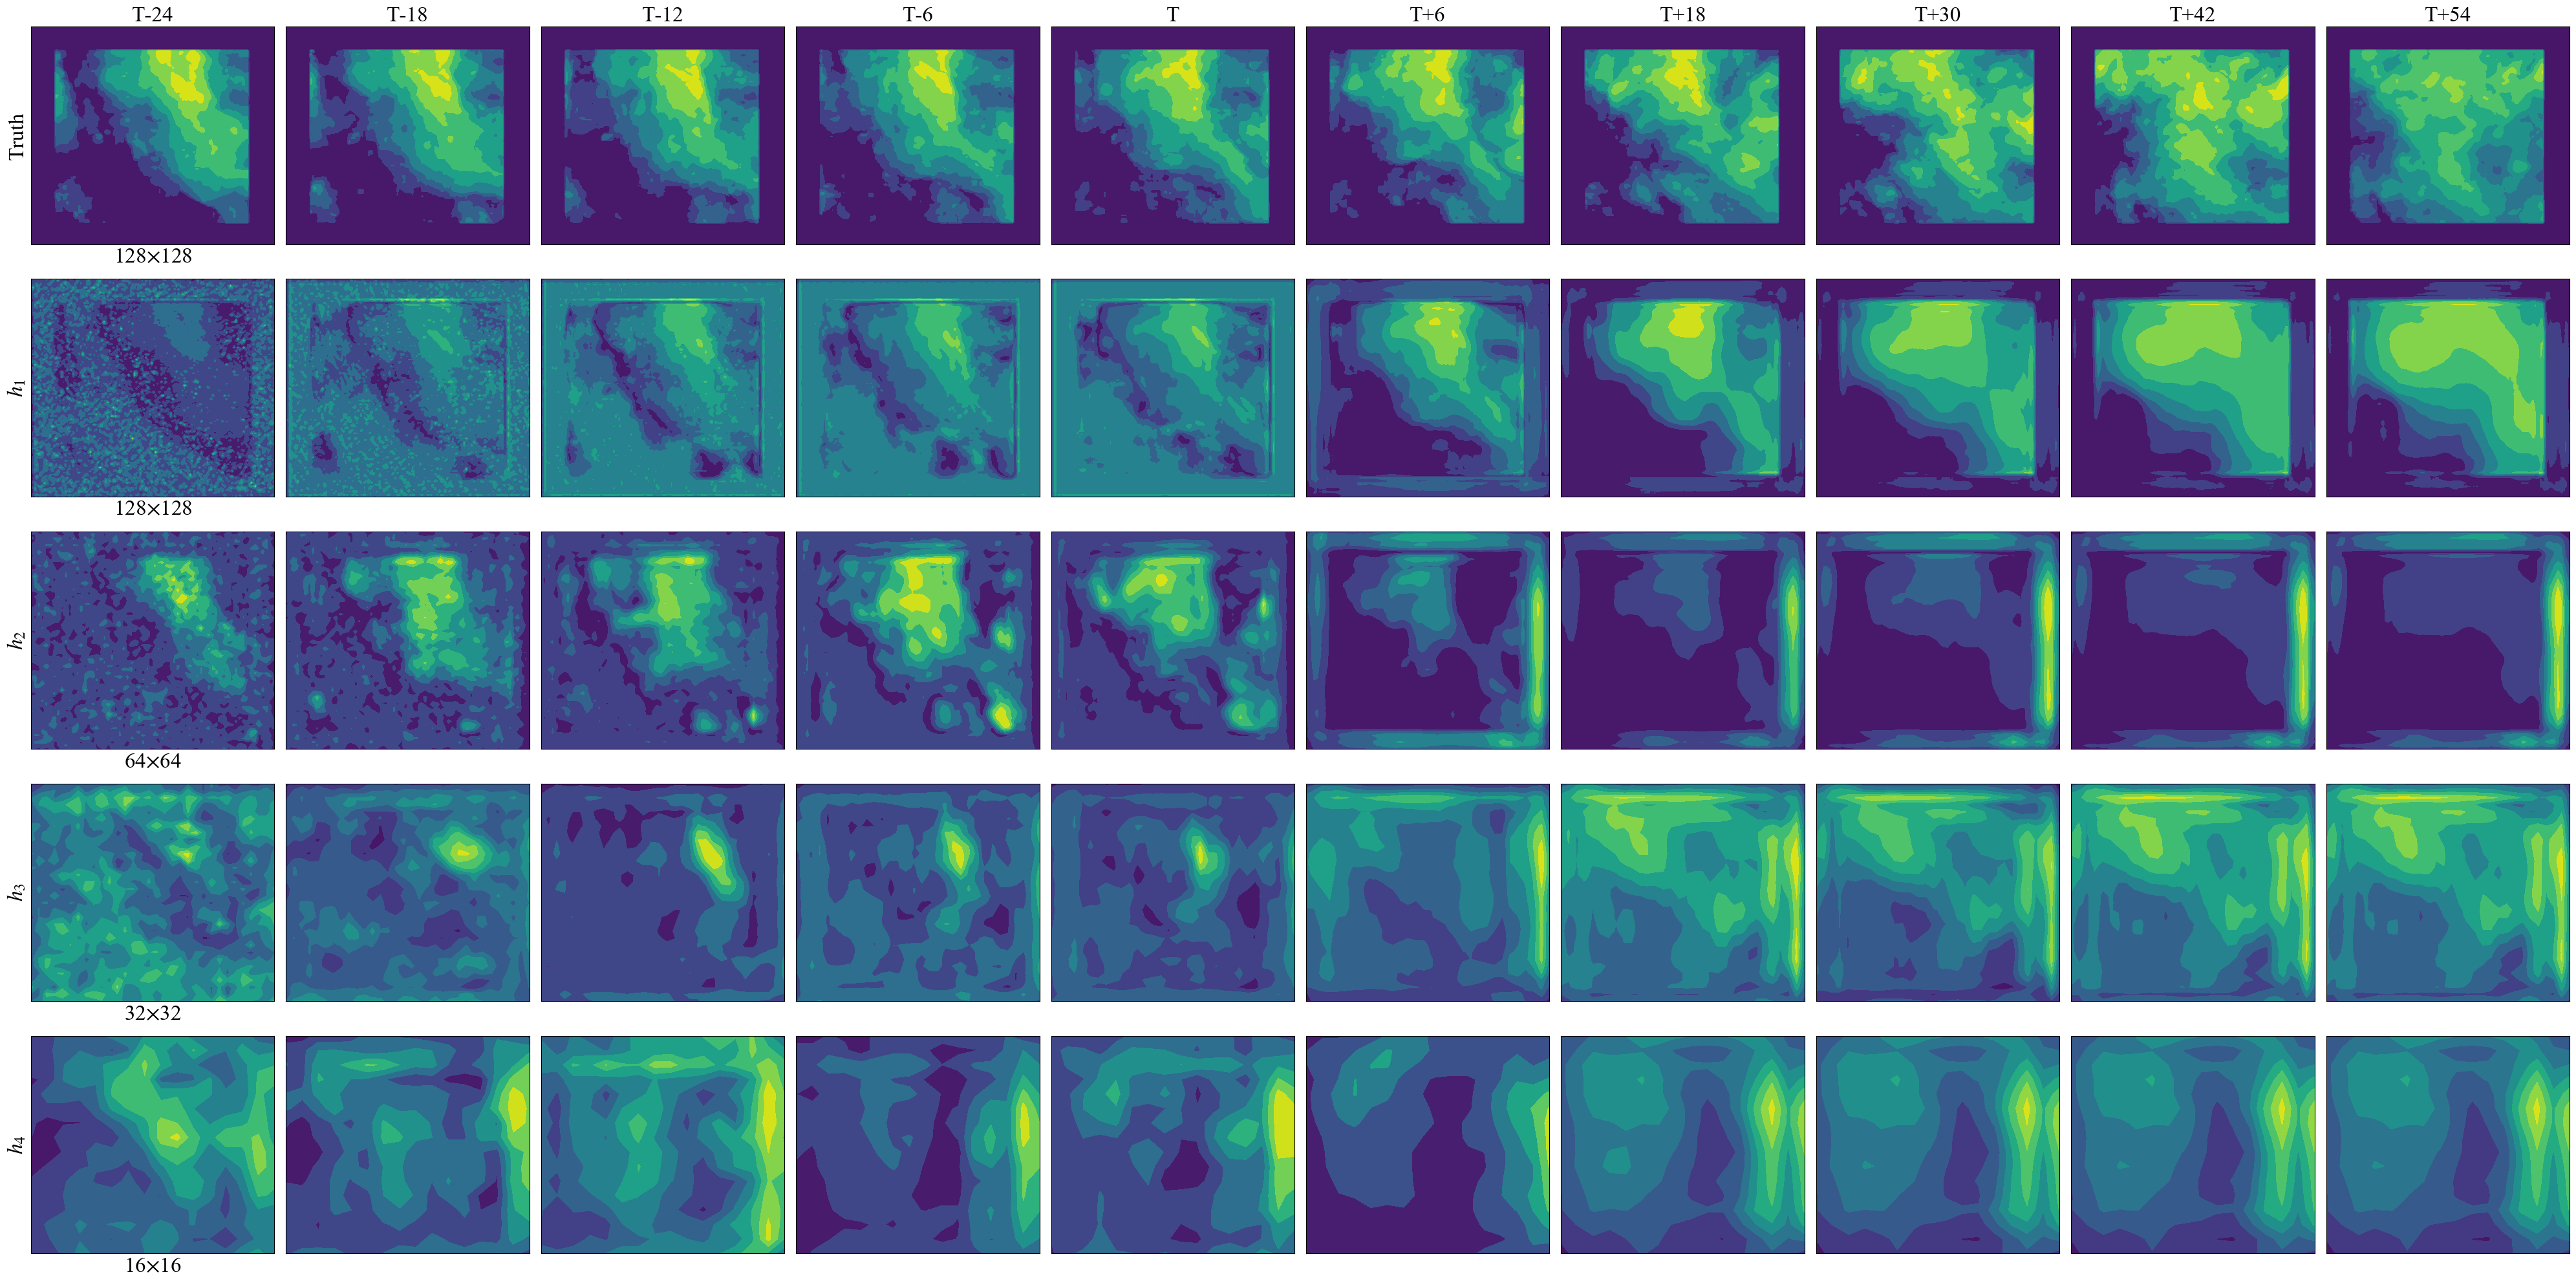

In [ ]:
# oshape=128
# b_i=7
# fig=plt.figure(figsize=(40,20))
# ax=fig.subplots(5,10)
# time=["-24","-18",'-12','-6','0','+6','+18','+30','+42','+54']
# for i,j in zip(range(0,10,1),[0,1,2,3,4,5,7,9,11,13]):
#     ax[0,i].contourf(range(0,oshape,1),range(0,oshape,1),realx[j,b_i,0,:,:])
#     ax[1,i].contourf(range(0,oshape,1),range(0,oshape,1),te1[j,b_i,:,:,:].std(axis=0))
#     ax[2,i].contourf(range(0,64,1),range(0,64,1),te2[j,b_i,:,:,:].std(axis=0))
#     ax[3,i].contourf(range(0,32,1),range(0,32,1),te3[j,b_i,:,:,:].std(axis=0))
#     ax[4,i].contourf(range(0,16,1),range(0,16,1),te4[j,b_i,:,:,:].std(axis=0))
#     delxysticks(ax[0,i])
#     delxysticks(ax[1,i])
#     delxysticks(ax[2,i])
#     delxysticks(ax[3,i])
#     delxysticks(ax[4,i])
#     if i==4:
#         ax[0,i].set_title('T',fontsize=24,fontweight='bold')
#     else:
#         ax[0,i].set_title('T'+time[i],fontsize=24,fontweight='bold')
#     if i == 0:
#         ax[0,i].set_ylabel('Truth',fontsize=24,fontweight='bold')
#         ax[1,i].set_ylabel('$h_1$',fontsize=24,fontweight='bold')
#         ax[2,i].set_ylabel('$h_2$',fontsize=24,fontweight='bold')
#         ax[3,i].set_ylabel('$h_3$',fontsize=24,fontweight='bold')
#         ax[4,i].set_ylabel('$h_4$',fontsize=24,fontweight='bold')
#         ax[0,i].set_xlabel('128$\\times$128',fontsize=24,fontweight='bold')
#         ax[1,i].set_xlabel('128$\\times$128',fontsize=24,fontweight='bold')
#         ax[2,i].set_xlabel('64$\\times$64',fontsize=24,fontweight='bold')
#         ax[3,i].set_xlabel('32$\\times$32',fontsize=24,fontweight='bold')
#         ax[4,i].set_xlabel('16$\\times$16',fontsize=24,fontweight='bold')
# plt.tight_layout()
# plt.savefig('D:\\_毕业论文\\毕业论文\\picture\\tezheng1857.png',dpi=300,bbox_inches='tight')

In [9]:
# pysteps
outstep = steppre(inputxstep)

Computing STEPS nowcast
-----------------------

Inputs
------
input dimensions: 101x101
km/pixel:         1.0
time step:        6 minutes

Methods
-------
extrapolation:          semilagrangian
bandpass filter:        gaussian
decomposition:          fft
noise generator:        nonparametric
noise adjustment:       no
velocity perturbator:   bps
conditional statistics: no
precip. mask method:    incremental
probability matching:   cdf
FFT method:             numpy
domain:                 spatial

Parameters
----------
number of time steps:     10
ensemble size:            1
parallel threads:         1
number of cascade levels: 6
order of the AR(p) model: 2
velocity perturbations, parallel:      10.88,0.23,-7.68
velocity perturbations, perpendicular: 5.76,0.31,-2.72
precip. intensity threshold: -10.0
************************************************
* Correlation coefficients for cascade levels: *
************************************************
-----------------------------------------

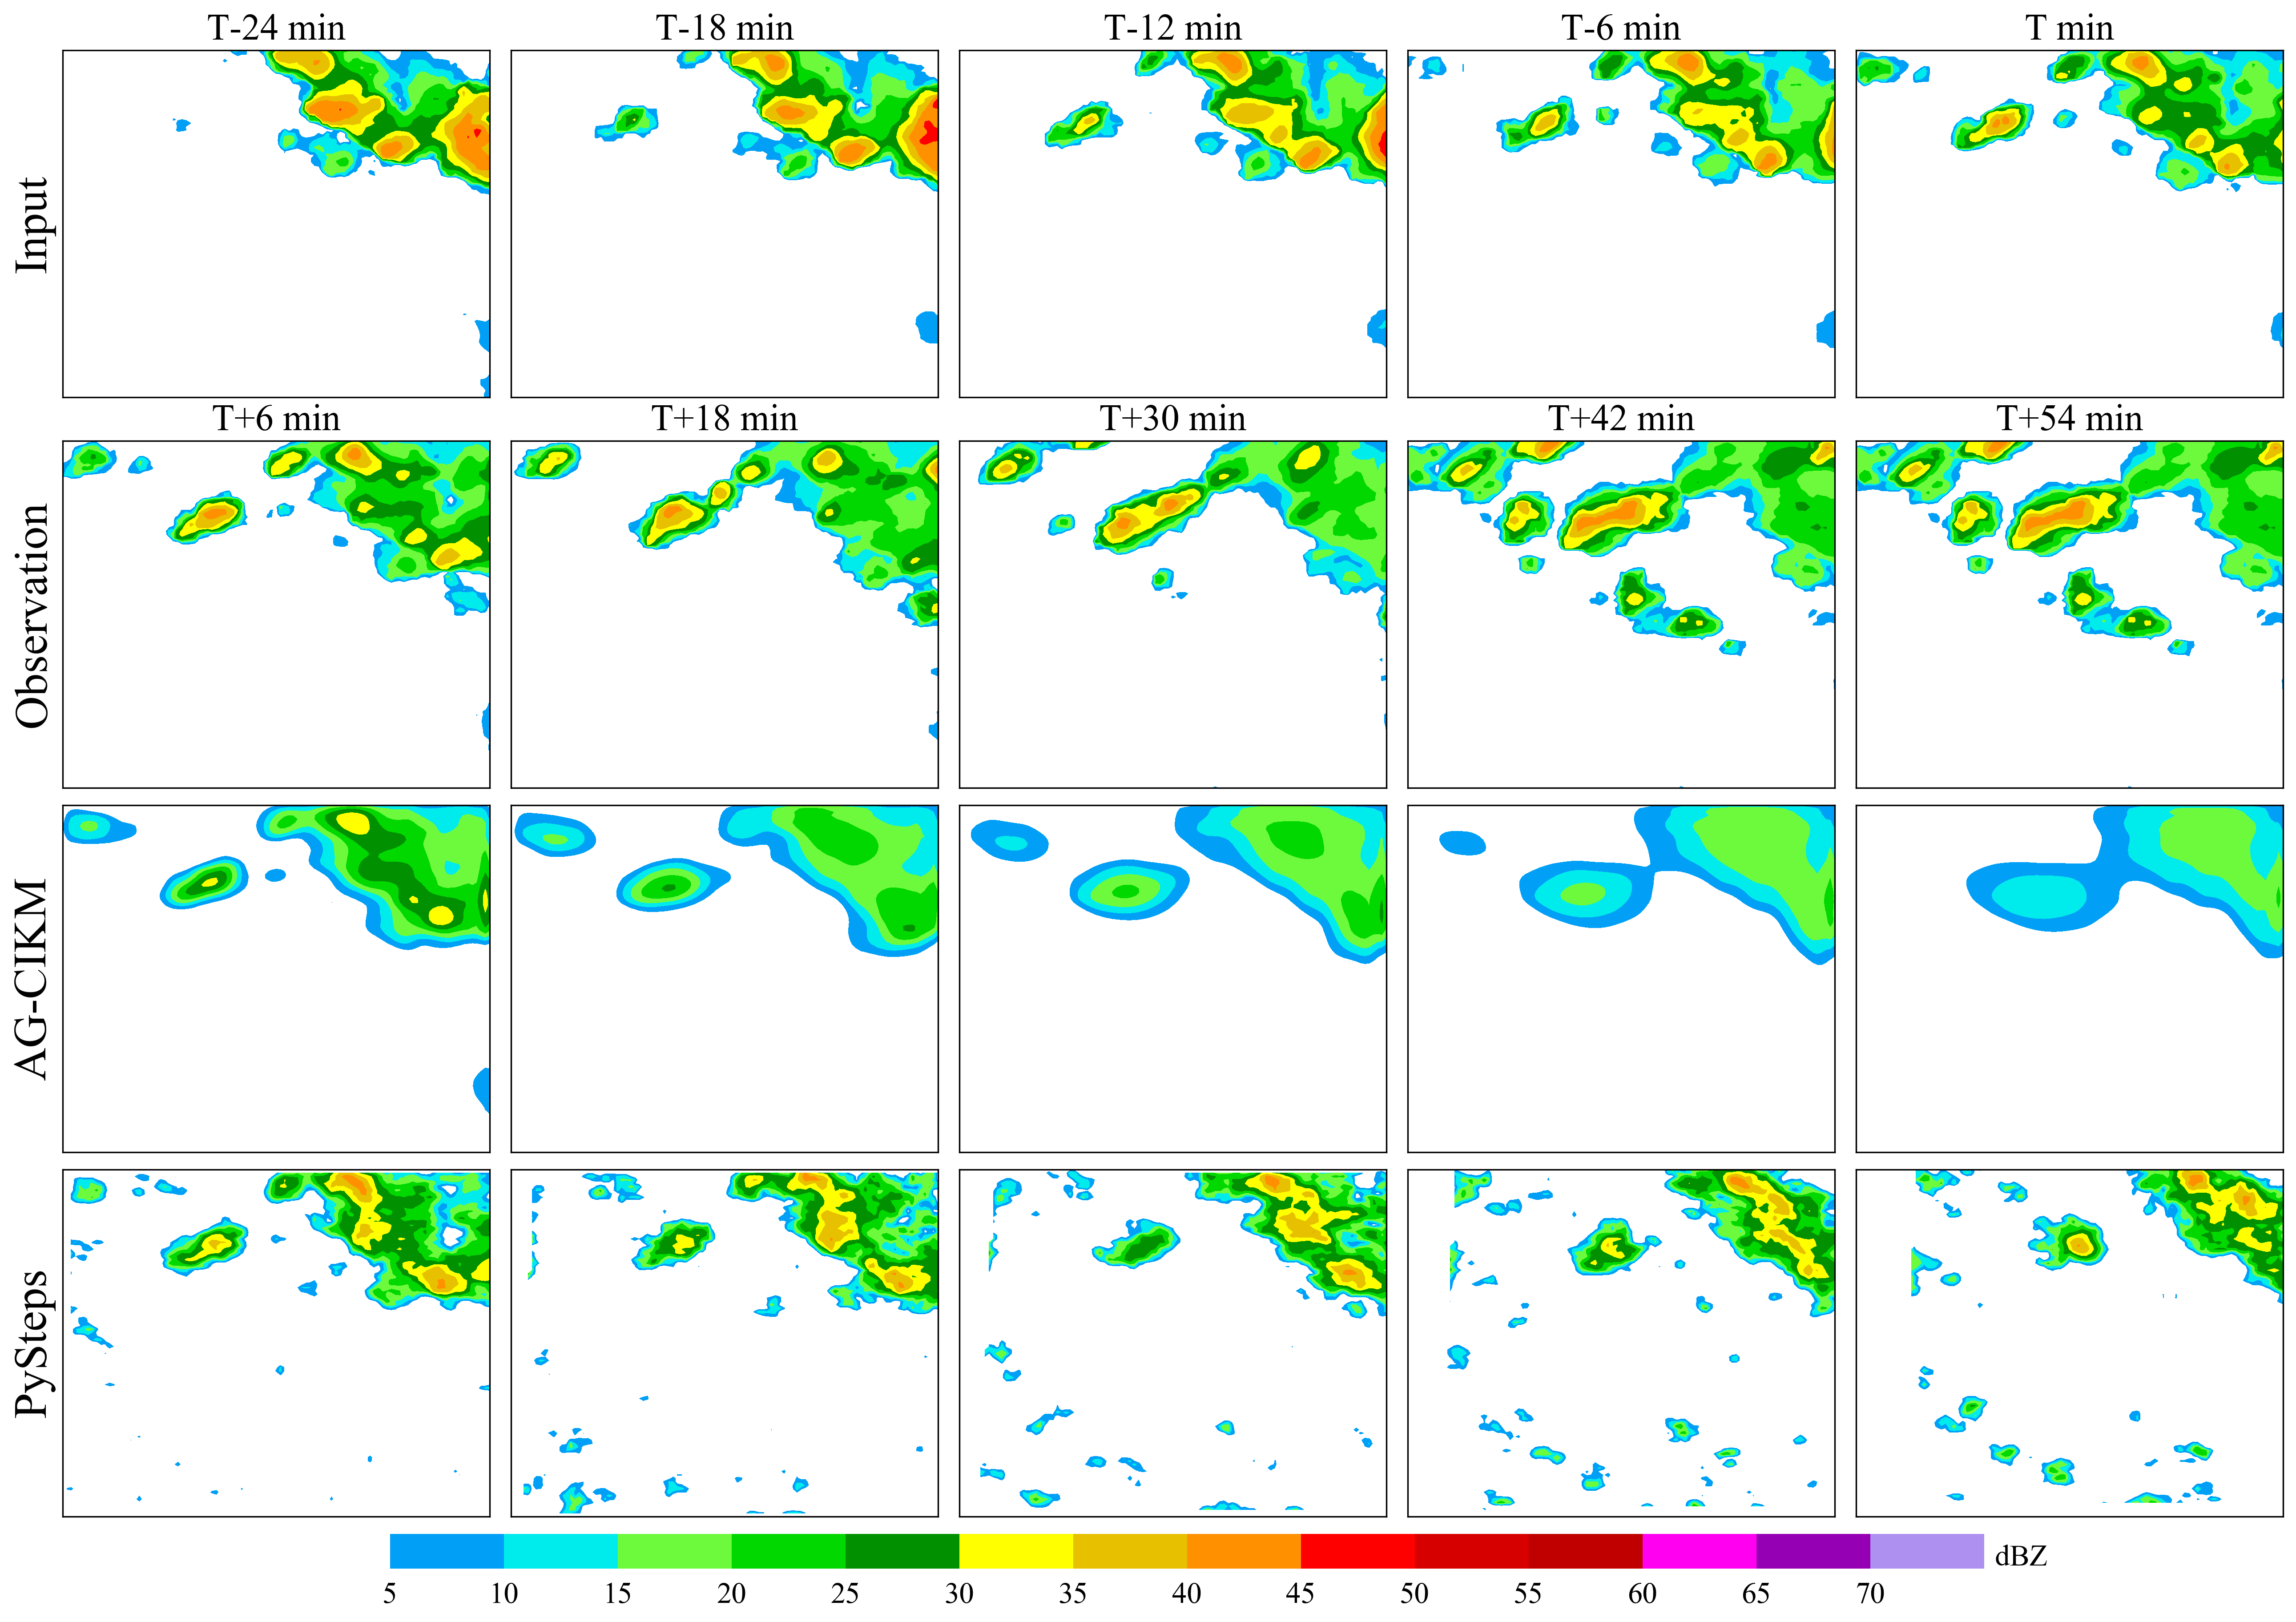

In [10]:
# 绘图
B_i=0
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16,13),dpi=300)
x1,x2,x3,x4,x5=0.05,0.26,0.47,0.68,0.89
y1,y2,y3,y4=0.13,0.34,0.55,0.775
# input
ax1=fig.add_axes([x1,y4,0.2,0.2])
colorbar=ax1.contourf(range(101),range(101),inputx[0,B_i,0,13:114,13:114],levels=levels,colors=colors)
ax1.set_title('T-24 min',fontsize=20,fontweight='bold')
delxysticks(ax1)
ax1.set_ylabel('Input',fontsize=25,fontweight='bold')

ax2=fig.add_axes([x2,y4,0.2,0.2])
ax2.contourf(range(101),range(101),inputx[1,B_i,0,13:114,13:114],levels=levels,colors=colors)
ax2.set_title('T-18 min',fontsize=20,fontweight='bold')
delxysticks(ax2)

ax3=fig.add_axes([x3,y4,0.2,0.2])
ax3.contourf(range(101),range(101),inputx[2,B_i,0,13:114,13:114],levels=levels,colors=colors)
ax3.set_title('T-12 min',fontsize=20,fontweight='bold')
delxysticks(ax3)

ax4=fig.add_axes([x4,y4,0.2,0.2])
ax4.contourf(range(101),range(101),inputx[3,B_i,0,13:114,13:114],levels=levels,colors=colors)
ax4.set_title('T-6 min',fontsize=20,fontweight='bold')
delxysticks(ax4)

ax5=fig.add_axes([x5,y4,0.2,0.2])
ax5.contourf(range(101),range(101),inputx[4,B_i,0,13:114,13:114],levels=levels,colors=colors)
ax5.set_title('T min',fontsize=20,fontweight='bold')
delxysticks(ax5)
# ax5.set_ylabel('Input',fontsize=25,fontweight='bold')
# ax5.yaxis.set_label_position('right')
# y
ax6=fig.add_axes([x1,y3,0.2,0.2])
ax6.set_title('T+6 min',fontsize=20,fontweight='bold')
ax6.contourf(range(101),range(101),y[0,B_i,0,13:114,13:114],levels=levels,colors=colors)
delxysticks(ax6)
ax6.set_ylabel('Observation',fontsize=25,fontweight='bold')

ax7=fig.add_axes([x2,y3,0.2,0.2])
ax7.set_title('T+18 min',fontsize=20,fontweight='bold')
ax7.contourf(range(101),range(101),y[2,B_i,0,13:114,13:114],levels=levels,colors=colors)
delxysticks(ax7)

ax8=fig.add_axes([x3,y3,0.2,0.2])
ax8.set_title('T+30 min',fontsize=20,fontweight='bold')
ax8.contourf(range(101),range(101),y[4,B_i,0,13:114,13:114],levels=levels,colors=colors)
delxysticks(ax8)

ax9=fig.add_axes([x4,y3,0.2,0.2])
ax9.set_title('T+42 min',fontsize=20,fontweight='bold')
ax9.contourf(range(101),range(101),y[6,B_i,0,13:114,13:114],levels=levels,colors=colors)
delxysticks(ax9)

ax10=fig.add_axes([x5,y3,0.2,0.2])
ax10.set_title('T+54 min',fontsize=20,fontweight='bold')
ax10.contourf(range(101),range(101),y[6,B_i,0,13:114,13:114],levels=levels,colors=colors)
delxysticks(ax10)
# ax10.set_ylabel('Observation',fontsize=25,fontweight='bold')
# ax10.yaxis.set_label_position('right')
# ourmodel
ax11=fig.add_axes([x1,y2,0.2,0.2])
ax11.contourf(range(101),range(101),out[0,B_i,0,13:114,13:114],levels=levels,colors=colors)
delxysticks(ax11)
ax11.set_ylabel('AG-CIKM',fontsize=25,fontweight='bold')

ax12=fig.add_axes([x2,y2,0.2,0.2])
ax12.contourf(range(101),range(101),out[2,B_i,0,13:114,13:114],levels=levels,colors=colors)
delxysticks(ax12)

ax13=fig.add_axes([x3,y2,0.2,0.2])
ax13.contourf(range(101),range(101),out[4,B_i,0,13:114,13:114],levels=levels,colors=colors)
delxysticks(ax13)

ax14=fig.add_axes([x4,y2,0.2,0.2])
ax14.contourf(range(101),range(101),out[6,B_i,0,13:114,13:114],levels=levels,colors=colors)
delxysticks(ax14)

ax15=fig.add_axes([x5,y2,0.2,0.2])
ax15.contourf(range(101),range(101),out[8,B_i,0,13:114,13:114],levels=levels,colors=colors)
delxysticks(ax15)
# ax15.set_ylabel('AG-CIKM',fontsize=25,fontweight='bold')
# ax15.yaxis.set_label_position('right')
# pysteps
ax16=fig.add_axes([x1,y1,0.2,0.2])
ax16.contourf(range(101),range(101),outstep[0,B_i,0,:,:],levels=levels,colors=colors)
delxysticks(ax16)
ax16.set_ylabel('PySteps',fontsize=25,fontweight='bold')

ax17=fig.add_axes([x2,y1,0.2,0.2])
ax17.contourf(range(101),range(101),outstep[2,B_i,0,:,:],levels=levels,colors=colors)
delxysticks(ax17)

ax18=fig.add_axes([x3,y1,0.2,0.2])
ax18.contourf(range(101),range(101),outstep[4,B_i,0,:,:],levels=levels,colors=colors)
delxysticks(ax18)

ax19=fig.add_axes([x4,y1,0.2,0.2])
ax19.contourf(range(101),range(101),outstep[6,B_i,0,:,:],levels=levels,colors=colors)
delxysticks(ax19)

ax20=fig.add_axes([x5,y1,0.2,0.2])
ax20.contourf(range(101),range(101),outstep[8,B_i,0,:,:],levels=levels,colors=colors)
delxysticks(ax20)
# ax20.set_ylabel('PySteps',fontsize=25,fontweight='bold')
# ax20.yaxis.set_label_position('right') 

axcolorbar=fig.add_axes([0.15,0.1,0.8,0.02])
axcolorbar.set_ylabel('        dBZ',fontsize=16,fontweight='bold',rotation=0,x=1,y=0.7)
axcolorbar.yaxis.set_label_position('right')
cb=plt.colorbar(colorbar,cax=axcolorbar,orientation='horizontal')
cb.ax.tick_params(labelsize=16,bottom=False)
cb.set_ticks([5,10,15,20,25,30,35,40,45,50,55,60,65,70])
cb.set_ticklabels(('5','10','15','20','25','30','35','40','45','50','55','60','65','70'))
cb.outline.set_visible(False)
plt.savefig('D:\\_毕业论文\\毕业论文\\picture\\mycg7.png',dpi=300,bbox_inches='tight')

In [11]:
from skimage.metrics import structural_similarity as ssim

In [12]:
y11=np.where(y[0,0,0,:,:]<=0,0,y[0,0,0,:,:])
y11[:,:].min()

0.0

In [13]:
ssim(y11, out[0,0,0, :, :].numpy(), win_size=11, gaussian_weights=True)

0.7917936657692565

In [14]:
import pandas as pd
CSIdf=pd.read_csv("D:\\Project\\DL_leida_rain\\evacsv\\CSI.csv")
CSIdf

,Unnamed: 0,20dBzPOD,30dBzPOD,40dBzPOD,5dBZPOD,20dBzPODstep,30dBzPODstep,40dBzPODstep,5dBZPODstep
0,0,0.33759,0.04289,0.0000,0.65551,0.07075,0.00357,0.00000,0.24171
1,1,0.55486,0.01000,0.0000,0.77926,0.18551,0.00000,0.00000,0.42113
2,2,0.59026,0.24441,0.0000,0.87099,0.34424,0.07687,0.00769,0.54657
3,3,0.48594,0.00000,0.0000,0.75440,0.14307,0.00000,0.00000,0.33518
4,4,0.48867,0.19048,0.0000,0.89349,0.25976,0.01470,0.00000,0.56317
...,...,...,...,...,...,...,...,...,...
1995,1995,0.29123,0.07275,0.0000,0.67893,0.36333,0.12800,0.08067,0.52376
1996,1996,0.10030,0.02429,0.0000,0.43541,0.29246,0.17603,0.00000,0.35422
1997,1997,0.29934,0.13885,0.0359,0.63745,0.25121,0.15966,0.04570,0.35090
1998,1998,0.31213,0.04276,0.0000,0.62331,0.27426,0.11002,0.00625,0.33182


In [15]:
def dfeva(df,name):
    dbz20=df['20dBz'+name][df['20dBz'+name]!=0].mean()
    dbz30=df['30dBz'+name][df['30dBz'+name]!=0].mean()
    dbz40=df['40dBz'+name][df['40dBz'+name]!=0].mean()
    dbz5=df['5dBZ'+name][df['5dBZ'+name]!=0].mean()

    dbz20step=df['20dBz'+name+'step'][df['20dBz'+name+'step']!=0].mean()
    dbz30step=df['30dBz'+name+'step'][df['30dBz'+name+'step']!=0].mean()
    dbz40step=df['40dBz'+name+'step'][df['40dBz'+name+'step']!=0].mean()
    dbz5step=df['5dBZ'+name+'step'][df['5dBZ'+name+'step']!=0].mean()
    return [dbz20,dbz30,dbz40,dbz5,dbz20step,dbz30step,dbz40step,dbz5step]

In [16]:
dfeva(CSIdf,'POD')

[0.4230362114314618,
 0.12812281197063807,
 0.04131300429184549,
 0.7006031815907954,
 0.33054708860759496,
 0.16291187285223366,
 0.09872454976303317,
 0.4905692072252885]

In [17]:
PODdf=pd.read_csv("D:\\Project\\DL_leida_rain\\evacsv\\POD.csv")
dfeva(PODdf,'POD')

[0.6513643045017703,
 0.33007486730660646,
 0.14301453505007153,
 0.7992650975487744,
 0.560101129113924,
 0.29004095074455905,
 0.18817130331753554,
 0.7702143753135975]

In [18]:
FARdf=pd.read_csv("D:\\Project\\DL_leida_rain\\evacsv\\FAR.csv")
dfeva(FARdf,'POD')

[0.32506449772842005,
 0.31133981759656654,
 0.18376210772833723,
 0.19872239777889955,
 0.43838397474747476,
 0.7068082747431044,
 0.7873466865671642,
 0.23297655854029395]

In [19]:
CSIlist=dfeva(CSIdf,'POD')
PODlist=dfeva(PODdf,'POD')
FARlist=dfeva(FARdf,'POD')

In [20]:
CSIlist[:4]

[0.4230362114314618,
 0.12812281197063807,
 0.04131300429184549,
 0.7006031815907954]

In [21]:
newCSIlist=[CSIlist[3],CSIlist[0],CSIlist[1],CSIlist[2],CSIlist[7],CSIlist[4],CSIlist[5],CSIlist[6]]

In [22]:
newPODlist=[PODlist[3],PODlist[0],PODlist[1],PODlist[2],PODlist[7],PODlist[4],PODlist[5],PODlist[6]]

In [23]:
newFARlist=[FARlist[3],FARlist[0],FARlist[1],FARlist[2],FARlist[7],FARlist[4],FARlist[5],FARlist[6]]

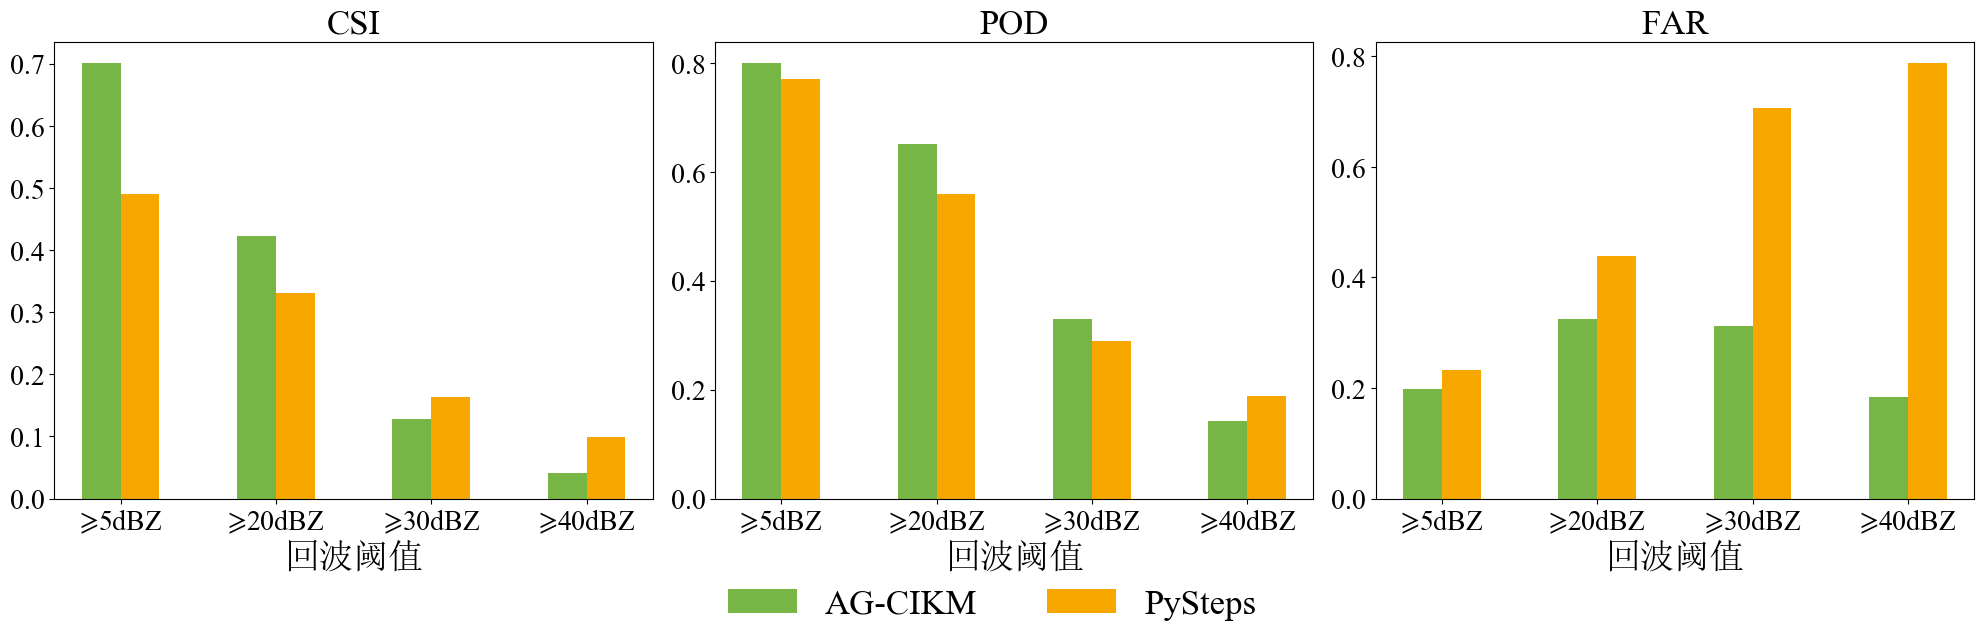

In [24]:
fig=plt.figure(figsize=(20,6))
labels = ['$\geqslant$5dBZ','$\geqslant$20dBZ', '$\geqslant$30dBZ', '$\geqslant$40dBZ']
x = np.arange(len(labels))  # x轴刻度标签位置
width = 0.25  # 柱子的宽度
ax1,ax2,ax3=fig.subplots(1,3)
ax1.bar(x-width/2,newCSIlist[:4],width,facecolor='#77b644',label='AG-CIKM')
ax1.bar(x+width/2,newCSIlist[4:],width,facecolor='#f8a700',label="PySteps")
ax1.set_xticks(x, labels=labels)
ax1.set_xlabel('回波阈值',fontsize=25)
ax1.set_title('CSI',fontsize=25)
ax1.tick_params(labelsize=20)

ax2.bar(x-width/2,newPODlist[:4],width,facecolor='#77b644')
ax2.bar(x+width/2,newPODlist[4:],width,facecolor='#f8a700')
ax2.set_xticks(x, labels=labels)
ax2.set_xlabel('回波阈值',fontsize=25)
ax2.set_title('POD',fontsize=25)
ax2.tick_params(labelsize=20)

ax3.bar(x-width/2,newFARlist[:4],width,facecolor='#77b644')
ax3.bar(x+width/2,newFARlist[4:],width,facecolor='#f8a700')
ax3.set_xticks(x, labels=labels)
ax3.set_xlabel('回波阈值',fontsize=25)
ax3.set_title('FAR',fontsize=25)
ax3.tick_params(labelsize=20)
fig.legend(loc = 'lower center',ncol=2,frameon = False,bbox_to_anchor=(0.5, -0.1),prop = {'size':25})
plt.tight_layout()
plt.savefig('D:\\_毕业论文\\毕业论文\\picture\\mytiao.png',dpi=300,bbox_inches='tight')

In [25]:
CSIdf

,Unnamed: 0,20dBzPOD,30dBzPOD,40dBzPOD,5dBZPOD,20dBzPODstep,30dBzPODstep,40dBzPODstep,5dBZPODstep
0,0,0.33759,0.04289,0.0000,0.65551,0.07075,0.00357,0.00000,0.24171
1,1,0.55486,0.01000,0.0000,0.77926,0.18551,0.00000,0.00000,0.42113
2,2,0.59026,0.24441,0.0000,0.87099,0.34424,0.07687,0.00769,0.54657
3,3,0.48594,0.00000,0.0000,0.75440,0.14307,0.00000,0.00000,0.33518
4,4,0.48867,0.19048,0.0000,0.89349,0.25976,0.01470,0.00000,0.56317
...,...,...,...,...,...,...,...,...,...
1995,1995,0.29123,0.07275,0.0000,0.67893,0.36333,0.12800,0.08067,0.52376
1996,1996,0.10030,0.02429,0.0000,0.43541,0.29246,0.17603,0.00000,0.35422
1997,1997,0.29934,0.13885,0.0359,0.63745,0.25121,0.15966,0.04570,0.35090
1998,1998,0.31213,0.04276,0.0000,0.62331,0.27426,0.11002,0.00625,0.33182


In [26]:
def creboxdata(df,name,num):
    if num==0:
        temp=df[name]
        temp=temp[temp!=0]
        return temp
    else:
        temp=df[name]
        temp=temp[temp!=0]
        return temp


In [27]:
def boxdata(df):
    boxdata=[creboxdata(df,'5dBZPOD',0),creboxdata(df,'20dBzPOD',0),creboxdata(df,'30dBzPOD',0),creboxdata(df,'40dBzPOD',0)]
    boxdata1=[creboxdata(df,'5dBZPODstep',0),creboxdata(df,'20dBzPODstep',0),creboxdata(df,'30dBzPODstep',0),creboxdata(df,'40dBzPODstep',0)]
    return [boxdata,boxdata1]

In [28]:
color_list = ['#e08d8f', '#7fa2ea']
x_labels = ['$\geqslant$5dBZ','$\geqslant$20dBZ', '$\geqslant$30dBZ', '$\geqslant$40dBZ']

length = len(x_labels)
x_loc = np.arange(length)
group_number = 2
total_width = 0.6
box_total_width = total_width * 0.65
# 两个箱线图之间的距离
interval_total_width = total_width * 0.2 
box_width = box_total_width / group_number
#
if group_number == 1:
    interval_width = interval_total_width
else:
    interval_width = interval_total_width / (group_number - 1)
#
if group_number % 2 == 0:
    x1_box = x_loc - (group_number / 2 - 1) * box_width - box_width / 2 - (group_number / 2 - 1) * interval_width - interval_width / 2
else:
    x1_box = x_loc - ((group_number - 1) / 2) * box_width - ((group_number - 1) / 2) * interval_width
x_list_box = [x1_box + box_width * i + interval_width * i for i in range(group_number)]

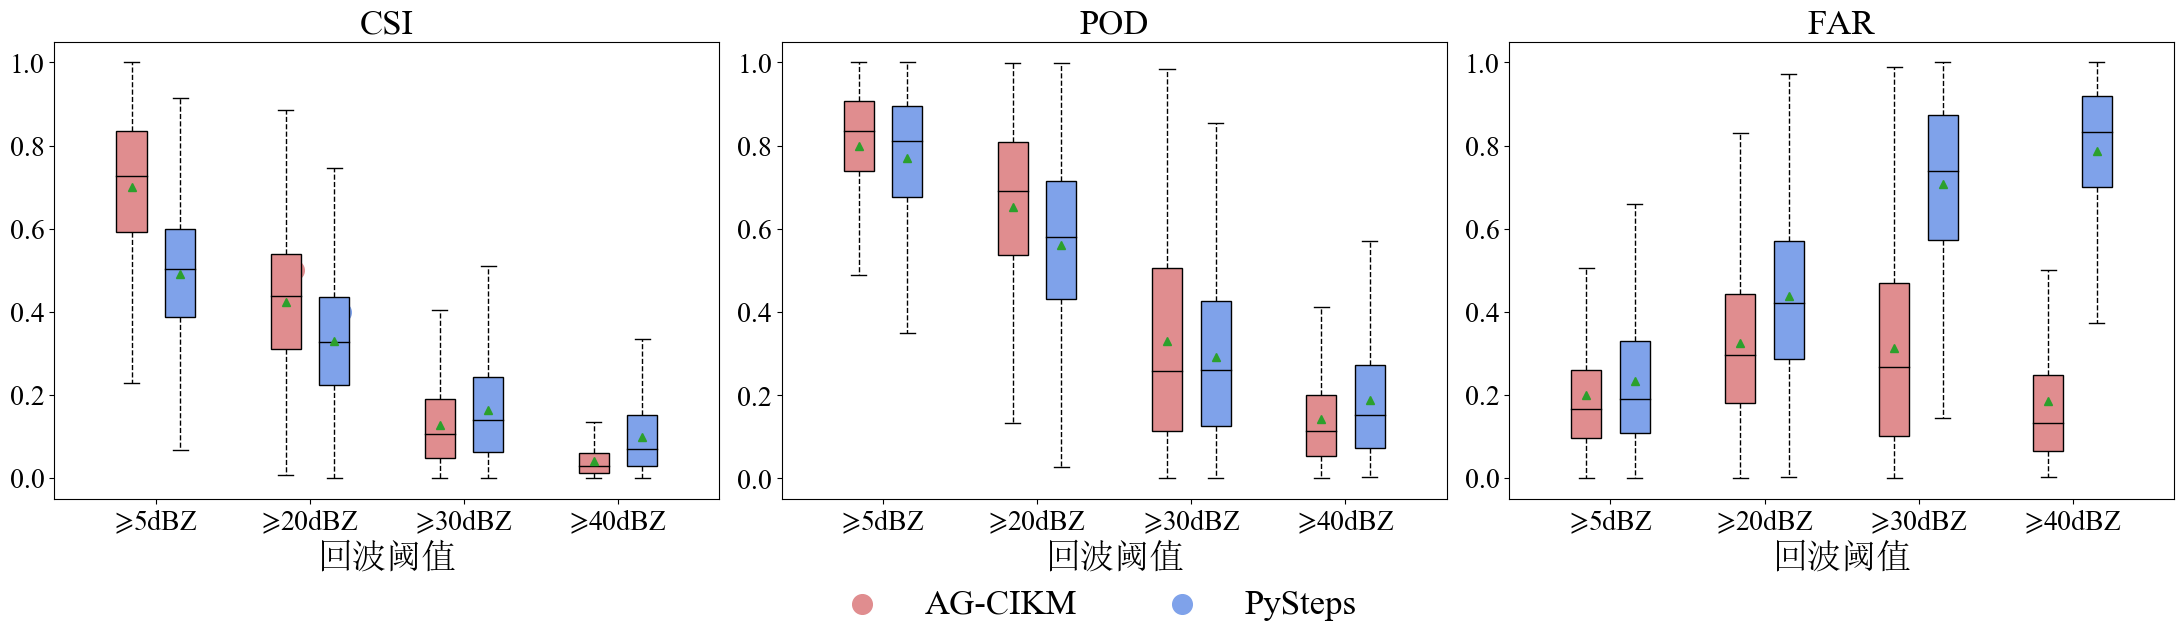

In [29]:
fig=plt.figure(figsize=(22,6))
ax=fig.subplots(1,3)
# CSI
# 图例设置
ax[0].scatter(0.9,0.5,color=color_list[0],label='AG-CIKM',s=200)
ax[0].scatter(1.2,0.4,color=color_list[1],label='PySteps',s=200)

boxplot_data=boxdata(CSIdf)
for i in range(len(boxplot_data)):
    ax[0].boxplot(boxplot_data[i], positions=x_list_box[i], widths=box_width, patch_artist=True,
               medianprops={'lw': 1, 'color': 'k'},
               boxprops={'facecolor': color_list[i], 'edgecolor': 'k'},
               capprops={'lw': 1, 'color': 'k'},
               whiskerprops={'ls': '--', 'lw': 1, 'color': 'k'},
               showfliers=False, zorder=1,showmeans=True)

ax[0].set_xticks(x_loc)
ax[0].set_xticklabels(x_labels, rotation=0)
ax[0].tick_params(labelsize=20)
ax[0].set_xlabel('回波阈值',fontsize=25)
ax[0].set_title('CSI',fontsize=25)

# POD
boxplot_data=boxdata(PODdf)
for i in range(len(boxplot_data)):
    ax[1].boxplot(boxplot_data[i], positions=x_list_box[i], widths=box_width, patch_artist=True,
               medianprops={'lw': 1, 'color': 'k'},
               boxprops={'facecolor': color_list[i], 'edgecolor': 'k'},
               capprops={'lw': 1, 'color': 'k'},
               whiskerprops={'ls': '--', 'lw': 1, 'color': 'k'},
               showfliers=False, zorder=1,showmeans=True)

ax[1].set_xticks(x_loc)
ax[1].set_xticklabels(x_labels, rotation=0)
ax[1].tick_params(labelsize=20)
ax[1].set_xlabel('回波阈值',fontsize=25)
ax[1].set_title('POD',fontsize=25)

# FAR
# POD
boxplot_data=boxdata(FARdf)
for i in range(len(boxplot_data)):
    ax[2].boxplot(boxplot_data[i], positions=x_list_box[i], widths=box_width, patch_artist=True,
               medianprops={'lw': 1, 'color': 'k'},
               boxprops={'facecolor': color_list[i], 'edgecolor': 'k'},
               capprops={'lw': 1, 'color': 'k'},
               whiskerprops={'ls': '--', 'lw': 1, 'color': 'k'},
               showfliers=False, zorder=1,showmeans=True)

ax[2].set_xticks(x_loc)
ax[2].set_xticklabels(x_labels, rotation=0)
ax[2].tick_params(labelsize=20)
ax[2].set_xlabel('回波阈值',fontsize=25)
ax[2].set_title('FAR',fontsize=25)

fig.legend(loc = 'lower center',ncol=2,frameon = False,bbox_to_anchor=(0.5, -0.1),prop = {'size':25})
plt.tight_layout()
plt.savefig('D:\\_毕业论文\\毕业论文\\picture\\myxiang.png',dpi=300,bbox_inches='tight')

In [30]:
x_labels = ['MSE','SSIM']

length = len(x_labels)
x_loc = np.arange(length)
group_number = 2
total_width = 0.6
box_total_width = total_width * 0.65
# 两个箱线图之间的距离
interval_total_width = total_width * 0.2 
box_width = box_total_width / group_number
#
if group_number == 1:
    interval_width = interval_total_width
else:
    interval_width = interval_total_width / (group_number - 1)
#
if group_number % 2 == 0:
    x1_box = x_loc - (group_number / 2 - 1) * box_width - box_width / 2 - (group_number / 2 - 1) * interval_width - interval_width / 2
else:
    x1_box = x_loc - ((group_number - 1) / 2) * box_width - ((group_number - 1) / 2) * interval_width
x_list_box = [x1_box + box_width * i + interval_width * i for i in range(group_number)]

In [31]:
MSEdf=pd.read_csv("D:\\Project\\DL_leida_rain\\evacsv\\MSE.csv")
MSEdf

,Unnamed: 0,model,step
0,0,60.17264,191.09615
1,1,52.07319,213.57451
2,2,40.39431,181.77330
3,3,45.65203,201.43345
4,4,41.22178,203.10571
...,...,...,...
1995,1995,35.69614,77.58468
1996,1996,75.33701,92.81842
1997,1997,65.60578,144.27431
1998,1998,35.48443,80.40400


In [32]:
SSIMdf=pd.read_csv("D:\\Project\\DL_leida_rain\\evacsv\\SSIM.csv")
SSIMdf

,Unnamed: 0,model,step
0,0,0.09941,0.03957
1,1,0.11854,0.02777
2,2,0.08643,0.04401
3,3,0.14323,0.03383
4,4,0.09158,0.01466
...,...,...,...
1995,1995,0.51348,0.09755
1996,1996,0.46414,0.07701
1997,1997,0.33826,0.04615
1998,1998,0.59810,0.04825


In [33]:
boxdata=[MSEdf['model'].values,MSEdf['step'].values]
boxdata1=[SSIMdf['model'].values,SSIMdf['step'].values]
boxplot_data=[boxdata,boxdata1]

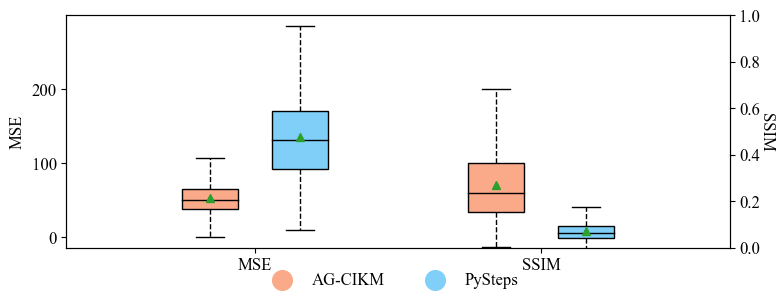

In [34]:
fig=plt.figure(figsize=(8,3))
ax=fig.subplots(1,1)

ax.boxplot(MSEdf['model'].values, positions=[x_list_box[0][0]], widths=box_width, patch_artist=True,
               medianprops={'lw': 1, 'color': 'k'},
               boxprops={'facecolor': '#faaa89', 'edgecolor': 'k'},
               capprops={'lw': 1, 'color': 'k'},
               whiskerprops={'ls': '--', 'lw': 1, 'color': 'k'},
               showfliers=False, zorder=1,showmeans=True)

ax.boxplot(MSEdf['step'].values, positions=[x_list_box[1][0]], widths=box_width, patch_artist=True,
               medianprops={'lw': 1, 'color': 'k'},
               boxprops={'facecolor': '#7fcff8', 'edgecolor': 'k'},
               capprops={'lw': 1, 'color': 'k'},
               whiskerprops={'ls': '--', 'lw': 1, 'color': 'k'},
               showfliers=False, zorder=1,showmeans=True)
ax.set_ylabel('MSE')


ax1=ax.twinx()
ax1.boxplot(SSIMdf['model'].values, positions=[x_list_box[0][1]], widths=box_width, patch_artist=True,
               medianprops={'lw': 1, 'color': 'k'},
               boxprops={'facecolor': '#faaa89', 'edgecolor': 'k'},
               capprops={'lw': 1, 'color': 'k'},
               whiskerprops={'ls': '--', 'lw': 1, 'color': 'k'},
               showfliers=False, zorder=1,showmeans=True)

ax1.boxplot(SSIMdf['step'].values, positions=[x_list_box[1][1]], widths=box_width, patch_artist=True,
               medianprops={'lw': 1, 'color': 'k'},
               boxprops={'facecolor': '#7fcff8', 'edgecolor': 'k'},
               capprops={'lw': 1, 'color': 'k'},
               whiskerprops={'ls': '--', 'lw': 1, 'color': 'k'},
               showfliers=False, zorder=1,showmeans=True)
ax1.set_ylim(0,1) 
ax1.set_ylabel('SSIM',rotation=-90,labelpad=10)
# 图例设置
ax.scatter(0.8,60,color='#faaa89',label='AG-CIKM',s=200)
ax.scatter(0.15,110,color='#7fcff8',label='PySteps',s=200)


ax.set_xticks(np.arange(2))
ax.set_xticklabels(x_labels)
fig.legend(loc = 'lower center',ncol=2,frameon = False,bbox_to_anchor=(0.5, -0.04),prop = {'size':12})
plt.tight_layout()
plt.savefig('D:\\_毕业论文\\毕业论文\\picture\\msexiang.png',dpi=300,bbox_inches='tight')


In [35]:
CSIdf=pd.read_csv("D:\\Project\\DL_leida_rain\\evacsv\\zTCSI.csv")
PODdf=pd.read_csv("D:\\Project\\DL_leida_rain\\evacsv\\zTPOD.csv")
FARdf=pd.read_csv("D:\\Project\\DL_leida_rain\\evacsv\\zTFAR.csv")
MSEdf=pd.read_csv("D:\\Project\\DL_leida_rain\\evacsv\\zTMSE.csv")
SSIMdf=pd.read_csv("D:\\Project\\DL_leida_rain\\evacsv\\zTSSIM.csv")

In [36]:
def a(df):
    return df.replace('[','').replace(']','')

In [37]:
dbz20=CSIdf['20dBzPOD'].apply(a).str.split(', ',expand=True).astype(np.float64)
dbz20

,0,1,2,3,4,5,6,7,8,9
0,0.67572,0.40246,0.28392,0.30703,0.27487,0.23018,0.24715,0.24514,0.27056,0.26655
1,0.64631,0.53316,0.42458,0.43137,0.44153,0.45402,0.46084,0.49676,0.50426,0.48059
2,0.71758,0.58037,0.51571,0.50846,0.48215,0.53578,0.55234,0.54073,0.51604,0.50099
3,0.62979,0.49920,0.32684,0.30863,0.34294,0.34625,0.33100,0.32792,0.30255,0.26954
4,0.66511,0.49736,0.34667,0.33466,0.33603,0.38062,0.39939,0.40810,0.40420,0.38929
...,...,...,...,...,...,...,...,...,...,...
1995,0.66667,0.67421,0.45537,0.37436,0.32703,0.20856,0.13074,0.06500,0.02356,0.00612
1996,0.51822,0.36559,0.12033,0.00808,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1997,0.70362,0.64334,0.47109,0.42512,0.33255,0.23643,0.13832,0.06229,0.02513,0.01061
1998,0.69945,0.56177,0.35358,0.29596,0.34083,0.31568,0.25280,0.15544,0.09403,0.02727


In [38]:
# MSE
mo=MSEdf['model'].apply(a).str.split(', ',expand=True).astype(np.float64)
molist=[mo[i][mo[i]!=0].mean() for i in range(10)]
pystep=MSEdf['step'].apply(a).str.split(', ',expand=True).astype(np.float64)
pysteplist=[pystep[i][pystep[i]!=0].mean() for i in range(10)]

In [39]:
# SSIM
moss=SSIMdf['model'].apply(a).str.split(', ',expand=True).astype(np.float64)
mosslist=[moss[i][moss[i]!=0].mean() for i in range(10)]
pystepss=SSIMdf['step'].apply(a).str.split(', ',expand=True).astype(np.float64)
pystepsslist=[pystepss[i][pystepss[i]!=0].mean() for i in range(10)]

In [40]:
def comdf(df,num):
    dbz20=df[str(num)+'dBzPOD'].apply(a).str.split(', ',expand=True).astype(np.float64)
    return [dbz20[i][dbz20[i]!=0].mean() for i in range(10)]
def comdfstep(df,num):
    dbz20=df[str(num)+'dBzPODstep'].apply(a).str.split(', ',expand=True).astype(np.float64)
    return [dbz20[i][dbz20[i]!=0].mean() for i in range(10)]
def comdffar(df,num):
    dbz20=df[str(num)+'dBzPOD'].apply(a).str.split(', ',expand=True).astype(np.float64)
    return [dbz20[i].mean() for i in range(10)]
def comdffarstep(df,num):
    dbz20=df[str(num)+'dBzPODstep'].apply(a).str.split(', ',expand=True).astype(np.float64)
    return [dbz20[i].mean() for i in range(10)]

In [41]:
dbz20CSI=comdf(CSIdf,20)
dbz30CSI=comdf(CSIdf,30)
dbz40CSI=comdf(CSIdf,40)
dbz5CSI=comdf(CSIdf,5)
dbz20POD=comdf(PODdf,20)
dbz30POD=comdf(PODdf,30)
dbz40POD=comdf(PODdf,40)
dbz5POD=comdf(PODdf,5)
dbz20FAR=comdffar(FARdf,20)
dbz30FAR=comdffar(FARdf,30)
dbz40FAR=comdffar(FARdf,40)
dbz5FAR=comdffar(FARdf,5)

In [42]:
dbz20CSIstep=comdfstep(CSIdf,20)
dbz30CSIstep=comdfstep(CSIdf,30)
dbz40CSIstep=comdfstep(CSIdf,40)
dbz5CSIstep=comdfstep(CSIdf,5)
dbz20PODstep=comdfstep(PODdf,20)
dbz30PODstep=comdfstep(PODdf,30)
dbz40PODstep=comdfstep(PODdf,40)
dbz5PODstep=comdfstep(PODdf,5)
dbz20FARstep=comdffarstep(FARdf,20)
dbz30FARstep=comdffarstep(FARdf,30)
dbz40FARstep=comdffarstep(FARdf,40)
dbz5FARstep=comdffarstep(FARdf,5)

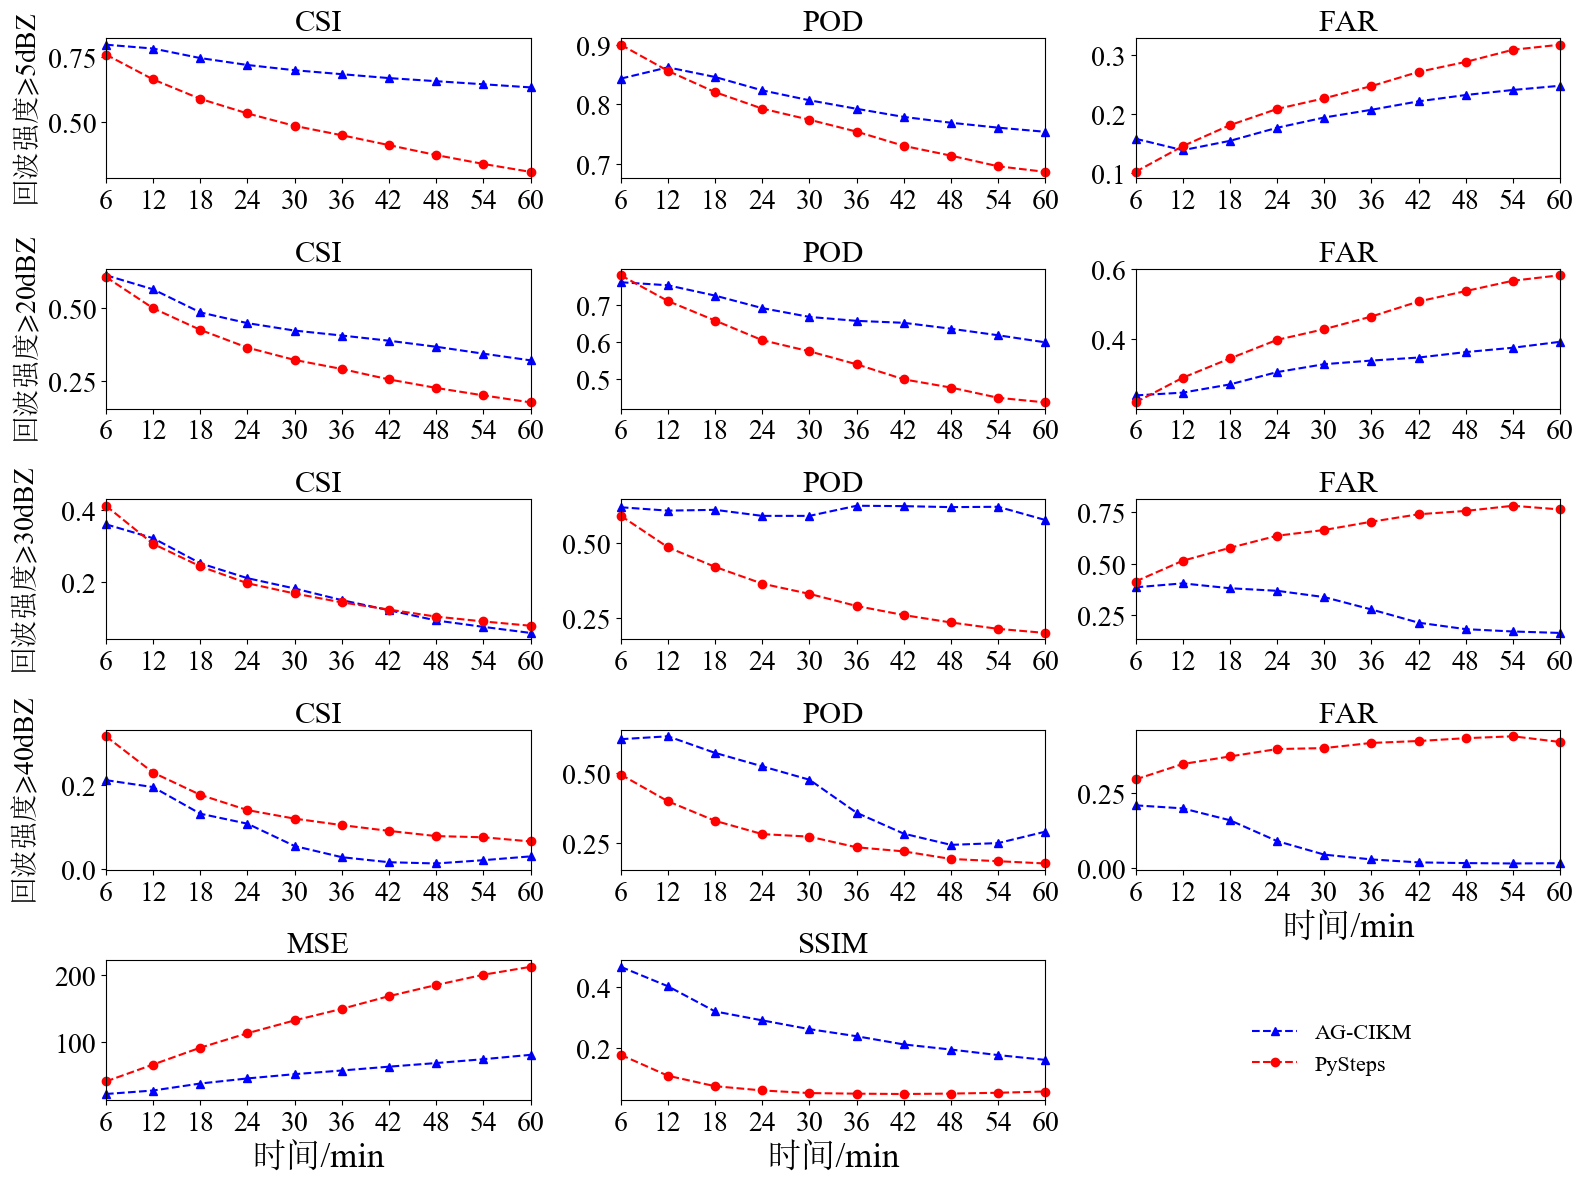

In [43]:
x=range(6,66,6)
fig=plt.figure(figsize=(16,12))
ax=fig.subplots(5,3)

ax[0,0].plot(x,dbz5CSI,marker='^',linestyle='--',color='b',label='AG-CIKM',clip_on=False)
ax[0,0].plot(x,dbz5CSIstep,marker='o',linestyle='--',color='r',label='PySteps',clip_on=False)
ax[0,0].set_ylabel('回波强度$\geqslant$5dBZ',fontsize=20,fontdict={'fontweight':'bold'})
ax[0,0].set_title('CSI',fontsize=22,fontdict={'fontweight':'bold'})

ax[0,1].plot(x,dbz5POD,marker='^',linestyle='--',color='b',clip_on=False)
ax[0,1].plot(x,dbz5PODstep,marker='o',linestyle='--',color='r',clip_on=False)
ax[0,1].set_title('POD',fontsize=22,fontdict={'fontweight':'bold'})

ax[0,2].plot(x,dbz5FAR,marker='^',linestyle='--',color='b',clip_on=False)
ax[0,2].plot(x,dbz5FARstep,marker='o',linestyle='--',color='r',clip_on=False)
ax[0,2].set_title('FAR',fontsize=22,fontdict={'fontweight':'bold'})

ax[1,0].plot(x,dbz20CSI,marker='^',linestyle='--',color='b',clip_on=False)
ax[1,0].plot(x,dbz20CSIstep,marker='o',linestyle='--',color='r',clip_on=False)
ax[1,0].set_ylabel('回波强度$\geqslant$20dBZ',fontsize=20,fontdict={'fontweight':'bold'})
ax[1,0].set_title('CSI',fontsize=22,fontdict={'fontweight':'bold'})

ax[1,1].plot(x,dbz20POD,marker='^',linestyle='--',color='b',clip_on=False)
ax[1,1].plot(x,dbz20PODstep,marker='o',linestyle='--',color='r',clip_on=False)
ax[1,1].set_title('POD',fontsize=22,fontdict={'fontweight':'bold'})

ax[1,2].plot(x,dbz20FAR,marker='^',linestyle='--',color='b',clip_on=False)
ax[1,2].plot(x,dbz20FARstep,marker='o',linestyle='--',color='r',clip_on=False)
ax[1,2].set_title('FAR',fontsize=22,fontdict={'fontweight':'bold'})

ax[2,0].plot(x,dbz30CSI,marker='^',linestyle='--',color='b',clip_on=False)
ax[2,0].plot(x,dbz30CSIstep,marker='o',linestyle='--',color='r',clip_on=False)
ax[2,0].set_ylabel('回波强度$\geqslant$30dBZ',fontsize=20,fontdict={'fontweight':'bold'},labelpad=15)
ax[2,0].set_title('CSI',fontsize=22,fontdict={'fontweight':'bold'})

ax[2,1].plot(x,dbz30POD,marker='^',linestyle='--',color='b',clip_on=False)
ax[2,1].plot(x,dbz30PODstep,marker='o',linestyle='--',color='r',clip_on=False)
ax[2,1].set_title('POD',fontsize=22,fontdict={'fontweight':'bold'})

ax[2,2].plot(x,dbz30FAR,marker='^',linestyle='--',color='b',clip_on=False)
ax[2,2].plot(x,dbz30FARstep,marker='o',linestyle='--',color='r',clip_on=False)
ax[2,2].set_title('FAR',fontsize=22,fontdict={'fontweight':'bold'})

ax[3,0].plot(x,dbz40CSI,marker='^',linestyle='--',color='b',clip_on=False)
ax[3,0].plot(x,dbz40CSIstep,marker='o',linestyle='--',color='r',clip_on=False)
ax[3,0].set_ylabel('回波强度$\geqslant$40dBZ',fontsize=20,fontdict={'fontweight':'bold'},labelpad=15)
ax[3,0].set_title('CSI',fontsize=22,fontdict={'fontweight':'bold'})


ax[3,1].plot(x,dbz40POD,marker='^',linestyle='--',color='b',clip_on=False)
ax[3,1].plot(x,dbz40PODstep,marker='o',linestyle='--',color='r',clip_on=False)
ax[3,1].set_title('POD',fontsize=22,fontdict={'fontweight':'bold'})

ax[3,2].plot(x,dbz40FAR,marker='^',linestyle='--',color='b',clip_on=False)
ax[3,2].plot(x,dbz40FARstep,marker='o',linestyle='--',color='r',clip_on=False)
ax[3,2].set_title('FAR',fontsize=22,fontdict={'fontweight':'bold'})
ax[3,2].set_xlabel('时间/min',fontsize=25,fontweight='bold')

ax[4,0].plot(x,molist,marker='^',linestyle='--',color='b',clip_on=False)
ax[4,0].plot(x,pysteplist,marker='o',linestyle='--',color='r',clip_on=False)
ax[4,0].set_title('MSE',fontsize=22,fontdict={'fontweight':'bold'})
ax[4,0].set_xlabel('时间/min',fontsize=25,fontweight='bold')

ax[4,1].plot(x,mosslist,marker='^',linestyle='--',color='b',clip_on=False)
ax[4,1].plot(x,pystepsslist,marker='o',linestyle='--',color='r',clip_on=False)
ax[4,1].set_title('SSIM',fontsize=22,fontdict={'fontweight':'bold'})
ax[4,1].set_xlabel('时间/min',fontsize=25,fontweight='bold')

for i in range(5):
    for j in range(3):
        if i==4 and j==2:
            break
        ax[i,j].set_xlim(6,60)
        ax[i,j].set_xticks(x)
        ax[i,j].tick_params(labelsize=20)
        

# ax[3,2].set_xticks([])
# ax[3,2].set_yticks([])
fig.legend(loc = 'lower right',ncol=1,bbox_to_anchor=(0.9, 0.08),frameon = False,prop = {'size':16})
plt.delaxes(ax=ax[4,2])
plt.tight_layout()
plt.savefig('D:\\_毕业论文\\毕业论文\\picture\\myzhe.png',dpi=300,bbox_inches='tight')

In [44]:
def comdf(df,num):
    dbz20=df[str(num)+'dBzPOD'].apply(a).str.split(', ',expand=True).astype(np.float64)
    return [np.round(dbz20[i][dbz20[i]!=0].mean(),3) for i in range(10)]
def comdfstep(df,num):
    dbz20=df[str(num)+'dBzPODstep'].apply(a).str.split(', ',expand=True).astype(np.float64)
    return [np.round(dbz20[i][dbz20[i]!=0].mean(),3) for i in range(10)]

In [45]:
# CSI
aaa=np.array([
    [np.mean(comdf(CSIdf,5)[:5]),np.mean(comdf(CSIdf,5)[5:]),np.mean(comdfstep(CSIdf,5)[:5]),np.mean(comdfstep(CSIdf,5)[5:])],
    [np.mean(comdf(CSIdf,20)[:5]),np.mean(comdf(CSIdf,20)[5:]),np.mean(comdfstep(CSIdf,20)[:5]),np.mean(comdfstep(CSIdf,20)[5:])],
    [np.mean(comdf(CSIdf,30)[:5]),np.mean(comdf(CSIdf,30)[5:]),np.mean(comdfstep(CSIdf,30)[:5]),np.mean(comdfstep(CSIdf,30)[5:])],
    [np.mean(comdf(CSIdf,40)[:5]),np.mean(comdf(CSIdf,40)[5:]),np.mean(comdfstep(CSIdf,40)[:5]),np.mean(comdfstep(CSIdf,40)[5:])],
])
aaa

array([[0.75  , 0.6586, 0.6072, 0.3768],
       [0.5072, 0.3656, 0.4444, 0.2304],
       [0.2654, 0.1   , 0.2654, 0.1084],
       [0.1404, 0.0216, 0.1966, 0.0834]])

In [46]:
# PDO
bbb=np.array([
    [np.mean(comdf(PODdf,5)[:5]),np.mean(comdf(PODdf,5)[5:]),np.mean(comdfstep(PODdf,5)[:5]),np.mean(comdfstep(PODdf,5)[5:])],
    [np.mean(comdf(PODdf,20)[:5]),np.mean(comdf(PODdf,20)[5:]),np.mean(comdfstep(PODdf,20)[:5]),np.mean(comdfstep(PODdf,20)[5:])],
    [np.mean(comdf(PODdf,30)[:5]),np.mean(comdf(PODdf,30)[5:]),np.mean(comdfstep(PODdf,30)[:5]),np.mean(comdfstep(PODdf,30)[5:])],
    [np.mean(comdf(PODdf,40)[:5]),np.mean(comdf(PODdf,40)[5:]),np.mean(comdfstep(PODdf,40)[:5]),np.mean(comdfstep(PODdf,40)[5:])],
])
bbb=np.round(bbb,3)
bbb

array([[0.837, 0.771, 0.829, 0.716],
       [0.72 , 0.632, 0.666, 0.481],
       [0.601, 0.61 , 0.438, 0.241],
       [0.566, 0.286, 0.356, 0.202]])

In [47]:
# FAR
ccc=np.array([
    [np.mean(comdffar(FARdf,5)[:5]),np.mean(comdffar(FARdf,5)[5:]),np.mean(comdffarstep(FARdf,5)[:5]),np.mean(comdffarstep(FARdf,5)[5:])],
    [np.mean(comdffar(FARdf,20)[:5]),np.mean(comdffar(FARdf,20)[5:]),np.mean(comdffarstep(FARdf,20)[:5]),np.mean(comdffarstep(FARdf,20)[5:])],
    [np.mean(comdffar(FARdf,30)[:5]),np.mean(comdffar(FARdf,30)[5:]),np.mean(comdffarstep(FARdf,30)[:5]),np.mean(comdffarstep(FARdf,30)[5:])],
    [np.mean(comdffar(FARdf,40)[:5]),np.mean(comdffar(FARdf,40)[5:]),np.mean(comdffarstep(FARdf,40)[:5]),np.mean(comdffarstep(FARdf,40)[5:])],
])
ccc=np.round(ccc,3)
ccc

array([[0.164, 0.23 , 0.172, 0.287],
       [0.278, 0.363, 0.336, 0.532],
       [0.376, 0.203, 0.56 , 0.747],
       [0.14 , 0.018, 0.363, 0.428]])

In [48]:
def cdf(df,name):
    dbz20=df[name].apply(a).str.split(', ',expand=True).astype(np.float64)
    return [np.round(dbz20[i][dbz20[i]!=0].mean(),3) for i in range(10)]

In [49]:
MSEmodel=cdf(MSEdf,'model')
MSEstep=cdf(MSEdf,'step')

In [50]:
SSIMmodel=cdf(SSIMdf,'model')
SSIMstep=cdf(SSIMdf,'step')

In [51]:
sum(MSEmodel[:5])/5,sum(MSEmodel[5:])/5

(37.0318, 68.7058)

In [52]:
sum(MSEstep[:5])/5,sum(MSEstep[5:])/5

(88.6686, 182.6752)

In [53]:
sum(SSIMmodel[:5])/5,sum(SSIMmodel[5:])/5

(0.347, 0.196)

In [54]:
sum(SSIMstep[:5])/5,sum(SSIMstep[5:])/5

(0.0948, 0.0524)

In [55]:
aaa[:,0]

array([0.75  , 0.5072, 0.2654, 0.1404])

<BarContainer object of 4 artists>

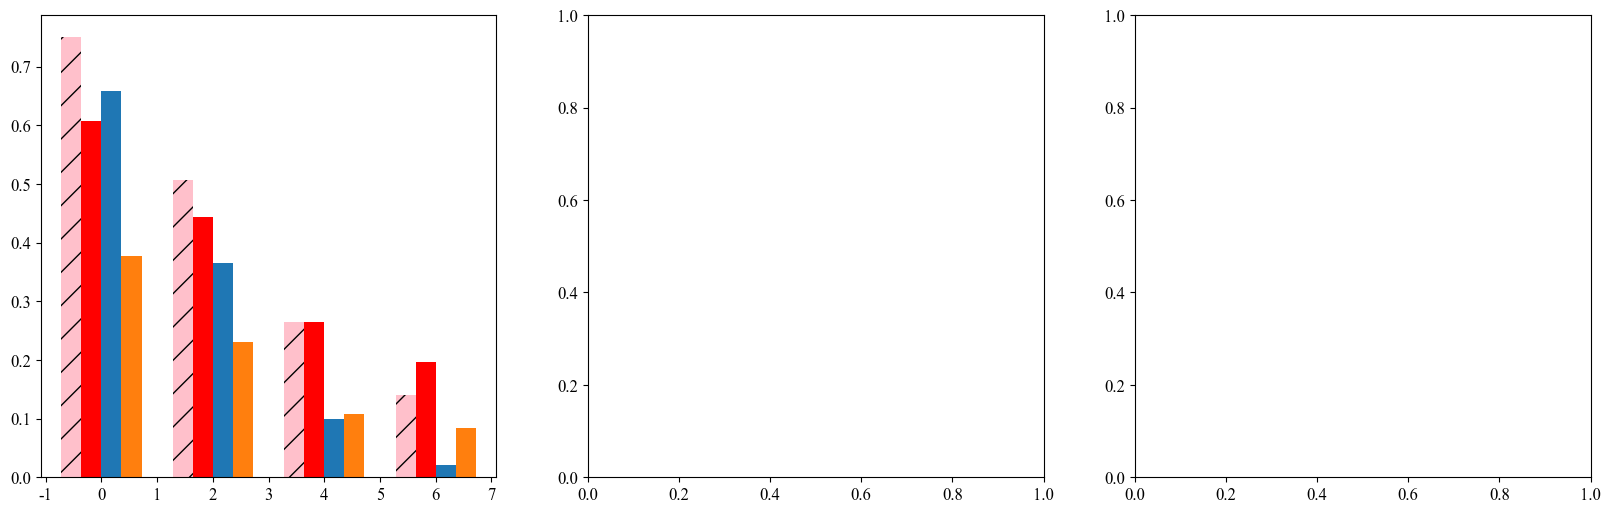

In [56]:
labels = ['$\geqslant$5dBZ','$\geqslant$20dBZ', '$\geqslant$30dBZ', '$\geqslant$40dBZ']
x = 2*np.arange(len(labels))  # x轴刻度标签位置
width = 0.36  # 柱子的宽度
fig=plt.figure(figsize=(20,6))
ax=fig.subplots(1,3)

# CSI
ax[0].bar(x-width*1.5,aaa[:,0],width,color='pink',hatch='/',label='a')
ax[0].bar(x-width/2,aaa[:,2],width,color='r')
ax[0].bar(x+width/2,aaa[:,1],width)
ax[0].bar(x+width*1.5,aaa[:,3],width)
# ax[0].legend()

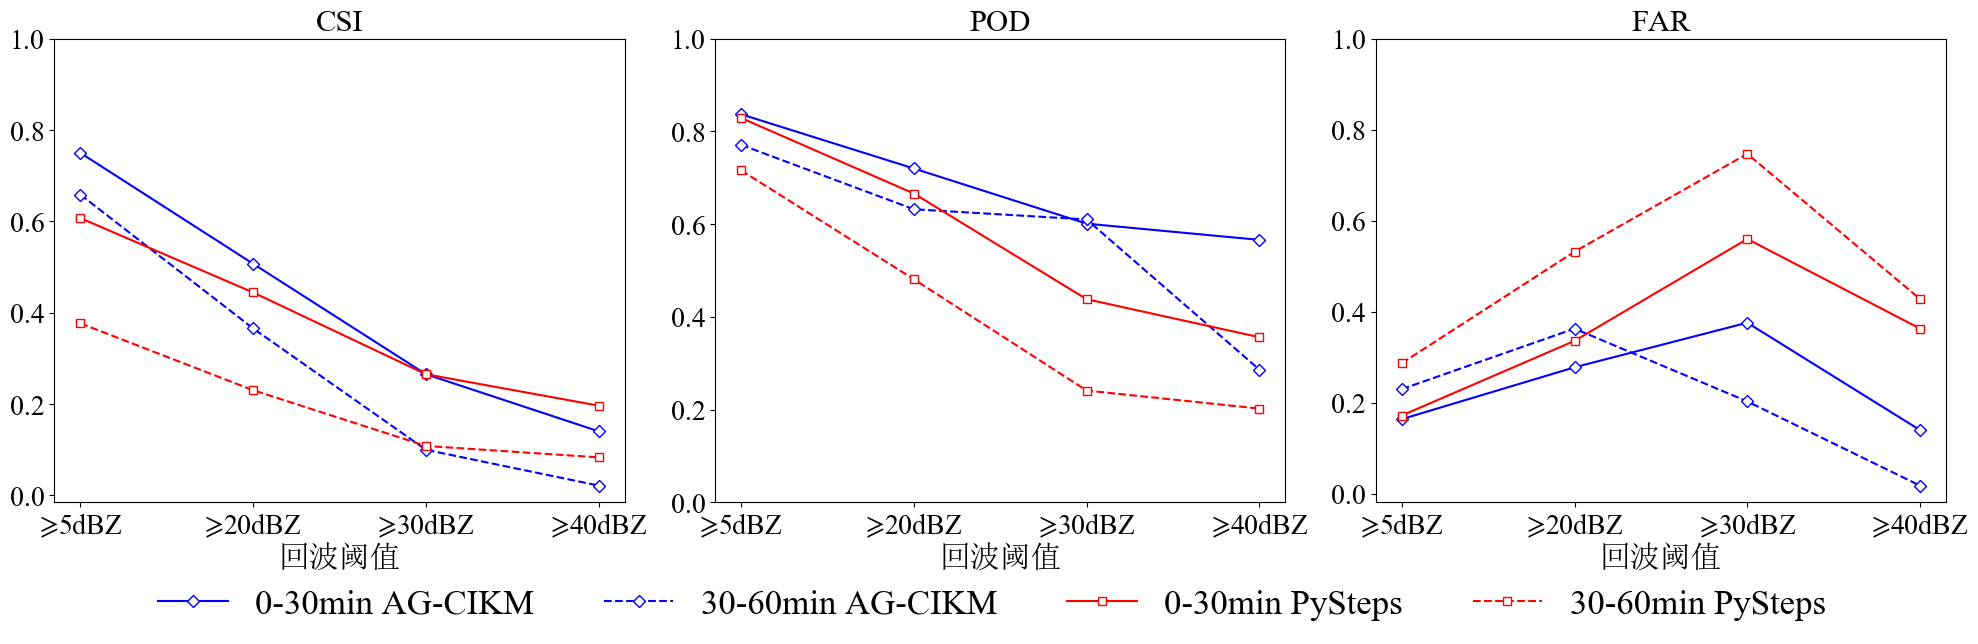

In [57]:
labels = ['$\geqslant$5dBZ','$\geqslant$20dBZ', '$\geqslant$30dBZ', '$\geqslant$40dBZ']
x = np.arange(len(labels))  # x轴刻度标签位置
width = 0.25  # 柱子的宽度
fig=plt.figure(figsize=(20,6))
ax=fig.subplots(1,3)
# CSI
ax[0].plot(labels,aaa[:,0],color='b',marker='D',markerfacecolor='white',label='0-30min AG-CIKM')
ax[0].plot(labels,aaa[:,1],color='b',marker='D',markerfacecolor='white',linestyle='--',label='30-60min AG-CIKM')
ax[0].plot(labels,aaa[:,2],color='r',marker='s',markerfacecolor='white',label='0-30min PySteps')
ax[0].plot(labels,aaa[:,3],color='r',marker='s',markerfacecolor='white',linestyle='--',label='30-60min PySteps')
ax[0].set_title('CSI',fontsize=22)
ax[0].set_xlabel('回波阈值',fontsize=22)

# POD
ax[1].plot(labels,bbb[:,0],color='b',marker='D',markerfacecolor='white')
ax[1].plot(labels,bbb[:,1],color='b',marker='D',markerfacecolor='white',linestyle='--')
ax[1].plot(labels,bbb[:,2],color='r',marker='s',markerfacecolor='white')
ax[1].plot(labels,bbb[:,3],color='r',marker='s',markerfacecolor='white',linestyle='--')
ax[1].set_title('POD',fontsize=22)
ax[1].set_xlabel('回波阈值',fontsize=22)

# FAR
ax[2].plot(labels,ccc[:,0],color='b',marker='D',markerfacecolor='white')
ax[2].plot(labels,ccc[:,1],color='b',marker='D',markerfacecolor='white',linestyle='--')
ax[2].plot(labels,ccc[:,2],color='r',marker='s',markerfacecolor='white')
ax[2].plot(labels,ccc[:,3],color='r',marker='s',markerfacecolor='white',linestyle='--')
ax[2].set_title('FAR',fontsize=22)
ax[2].set_xlabel('回波阈值',fontsize=22)

ax[0].tick_params(labelsize=20)
ax[1].tick_params(labelsize=20)
ax[2].tick_params(labelsize=20)
ax[0].set_yticks(np.arange(0,1.1,0.2))
ax[1].set_yticks(np.arange(0,1.1,0.2))
ax[2].set_yticks(np.arange(0,1.1,0.2))
fig.legend(loc = 'lower center',ncol=4,frameon = False,bbox_to_anchor=(0.5, -0.1),prop = {'size':25})
plt.tight_layout()
plt.savefig('D:\\_毕业论文\\毕业论文\\picture\\my30zhe.png',dpi=300,bbox_inches='tight')

In [58]:
aaa

array([[0.75  , 0.6586, 0.6072, 0.3768],
       [0.5072, 0.3656, 0.4444, 0.2304],
       [0.2654, 0.1   , 0.2654, 0.1084],
       [0.1404, 0.0216, 0.1966, 0.0834]])

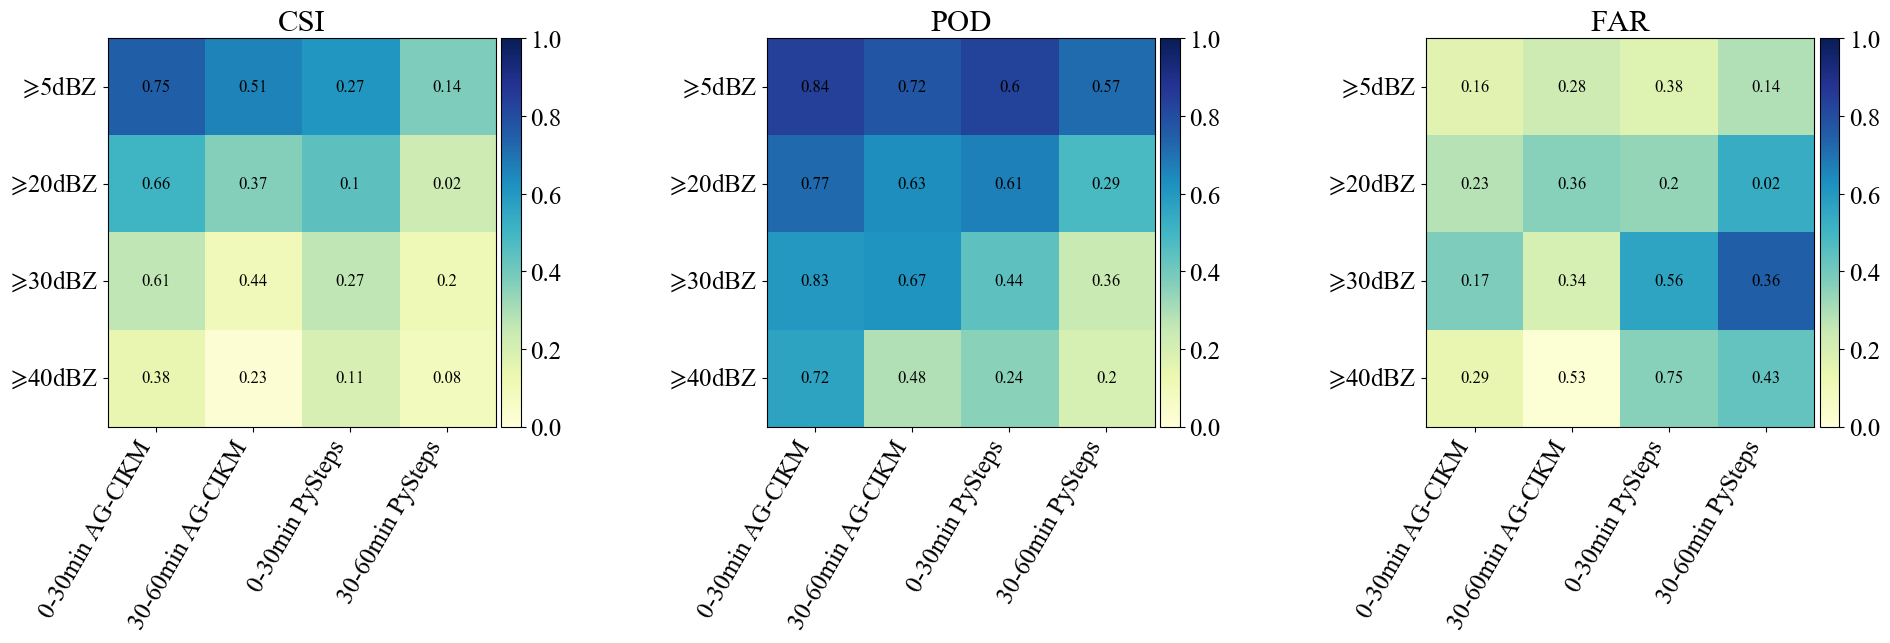

In [122]:
def seax(ax,cb,aaa):
    ax.tick_params(labelsize=18)
    ax.set_yticks(np.arange(0,4,1))
    ax.set_yticklabels(['$\geqslant$5dBZ','$\geqslant$20dBZ', '$\geqslant$30dBZ', '$\geqslant$40dBZ'],rotation=0, va="center")
    ax.set_xticks(np.arange(0,4,1))
    ax.set_xticklabels(['0-30min AG-CIKM','30-60min AG-CIKM','0-30min PySteps','30-60min PySteps'],rotation=60,ha='right')
    cblin=plt.colorbar(cb,ax=ax,shrink=1,pad=0.01)
    cblin.ax.tick_params(labelsize=18)
    cblin.ax.set_ylim(0,1)
    for i in range(4):
        for j in range(4):
            ax.text(x=i,y=j,s=str(round(aaa[i,j],2)),ha="center", va="center", color="k")

fig=plt.figure(figsize=(20,6))
ax=fig.subplots(1,3)

cb=ax[0].imshow(aaa,vmin=0,vmax=1,cmap="YlGnBu")
ax[0].set_title('CSI',fontsize=22)

cb1=ax[1].imshow(bbb,vmin=0,vmax=1,cmap="YlGnBu")
ax[1].set_title('POD',fontsize=22)

cb2=ax[2].imshow(ccc,vmin=0,vmax=1,cmap="YlGnBu")
ax[2].set_title('FAR',fontsize=22)


seax(ax[0],cb,aaa)
seax(ax[1],cb1,bbb)
seax(ax[2],cb2,ccc)
plt.tight_layout()
plt.savefig('D:\\_毕业论文\\毕业论文\\picture\\my30zhe.png',dpi=300,bbox_inches='tight')

In [58]:
# 雷达图
aaa.mean(axis=0)

array([0.41575, 0.28645, 0.3784 , 0.19975])

In [59]:
bbb.mean(axis=0)

array([0.681  , 0.57475, 0.57225, 0.41   ])

In [60]:
ccc.mean(axis=0)

array([0.2395 , 0.2035 , 0.35775, 0.4985 ])

In [61]:
MSEleida=[37.0318, 68.7058,88.6686, 182.6752]
SSIMleida=[0.347, 0.196,0.0948, 0.0524]

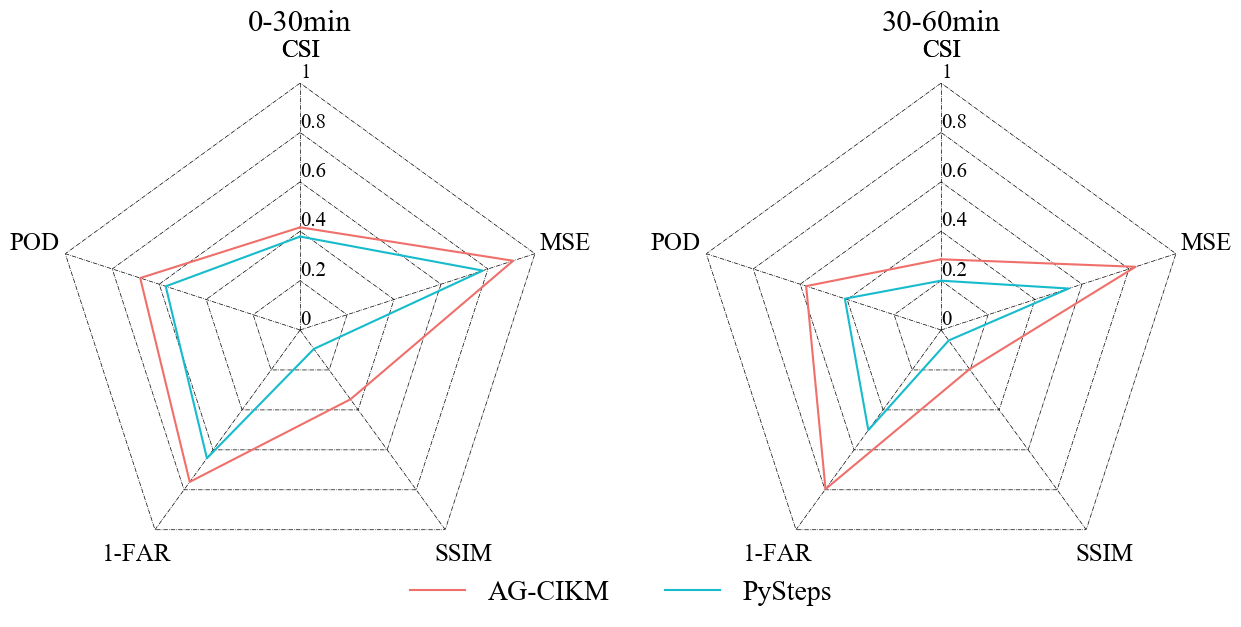

In [63]:
def seax(ax,theta):
    ax.set_xticks(theta,['CSI','POD','1-FAR','SSIM','MSE','CSI'],position=(0,-0.05),fontsize=18)
    # ax.set_xlabel(['CSI','POD','1-FAR','SSIM','MSE','CSI'],labelpad=1)
    ax.set_yticks(np.arange(0,1.1,0.2),['0','0.2','0.4','0.6','0.8','1'],fontsize=15)
    ax.set_ylim(0,1)
    ax.set_theta_zero_location('N')
    ax.set_rlabel_position(0)
    # 隐藏最外圈的圆
    ax.spines['polar'].set_visible(False)  
    # 隐藏圆形网格线
    ax.grid(False)

theta=np.linspace(0,np.pi*2,6)
model30lei=[aaa.mean(axis=0)[0],bbb.mean(axis=0)[0],1-ccc.mean(axis=0)[0],SSIMleida[0],1-MSEleida[0]/400,aaa.mean(axis=0)[0]]
step30lei=[aaa.mean(axis=0)[2],bbb.mean(axis=0)[2],1-ccc.mean(axis=0)[2],SSIMleida[2],1-MSEleida[2]/400,aaa.mean(axis=0)[2]]
modelhou30lei=[aaa.mean(axis=0)[1],bbb.mean(axis=0)[1],1-ccc.mean(axis=0)[1],SSIMleida[1],1-MSEleida[1]/400,aaa.mean(axis=0)[1]]
stephou30lei=[aaa.mean(axis=0)[3],bbb.mean(axis=0)[3],1-ccc.mean(axis=0)[3],SSIMleida[3],1-MSEleida[3]/400,aaa.mean(axis=0)[3]]
fig=plt.figure(figsize=(13,6))
ax=fig.subplots(1,2,subplot_kw={'projection': 'polar'})

for i in range(2):
    for j in np.arange(0, 1+0.2, 0.2):
        ax[i].plot(theta, 6*[j], '-.', lw=0.5, color='black')  #  沿半径方向的等值线
    for j in range(5):
        ax[i].plot([theta[j], theta[j]], [0, 1], '-.', lw=0.5, color='black')  #  绘制角度轴

seax(ax[0],theta)
ax[0].plot(theta,model30lei,color='#ef6f6a',label='AG-CIKM')
# ax.fill(theta,model30lei,color='#ff8971')
ax[0].plot(theta,step30lei,color='#16bbcc',label='PySteps')
# ax.fill(theta,step30lei,color='#1ceaff')
ax[0].set_title('0-30min',fontsize=22)

seax(ax[1],theta)
ax[1].plot(theta,modelhou30lei,color='#ef6f6a')
# ax.fill(theta,model30lei,color='#ff8971')
ax[1].plot(theta,stephou30lei,color='#16bbcc')
# ax.fill(theta,step30lei,color='#1ceaff')
ax[1].set_title('30-60min',fontsize=22)
fig.legend(loc = 'lower center',ncol=4,frameon = False,bbox_to_anchor=(0.5, -0.06),prop = {'size':20})
plt.tight_layout()
plt.savefig('D:\\_毕业论文\\毕业论文\\picture\\mylei.png',dpi=300,bbox_inches='tight')